# 读取表格数据，整理数据，保存整理后的数据

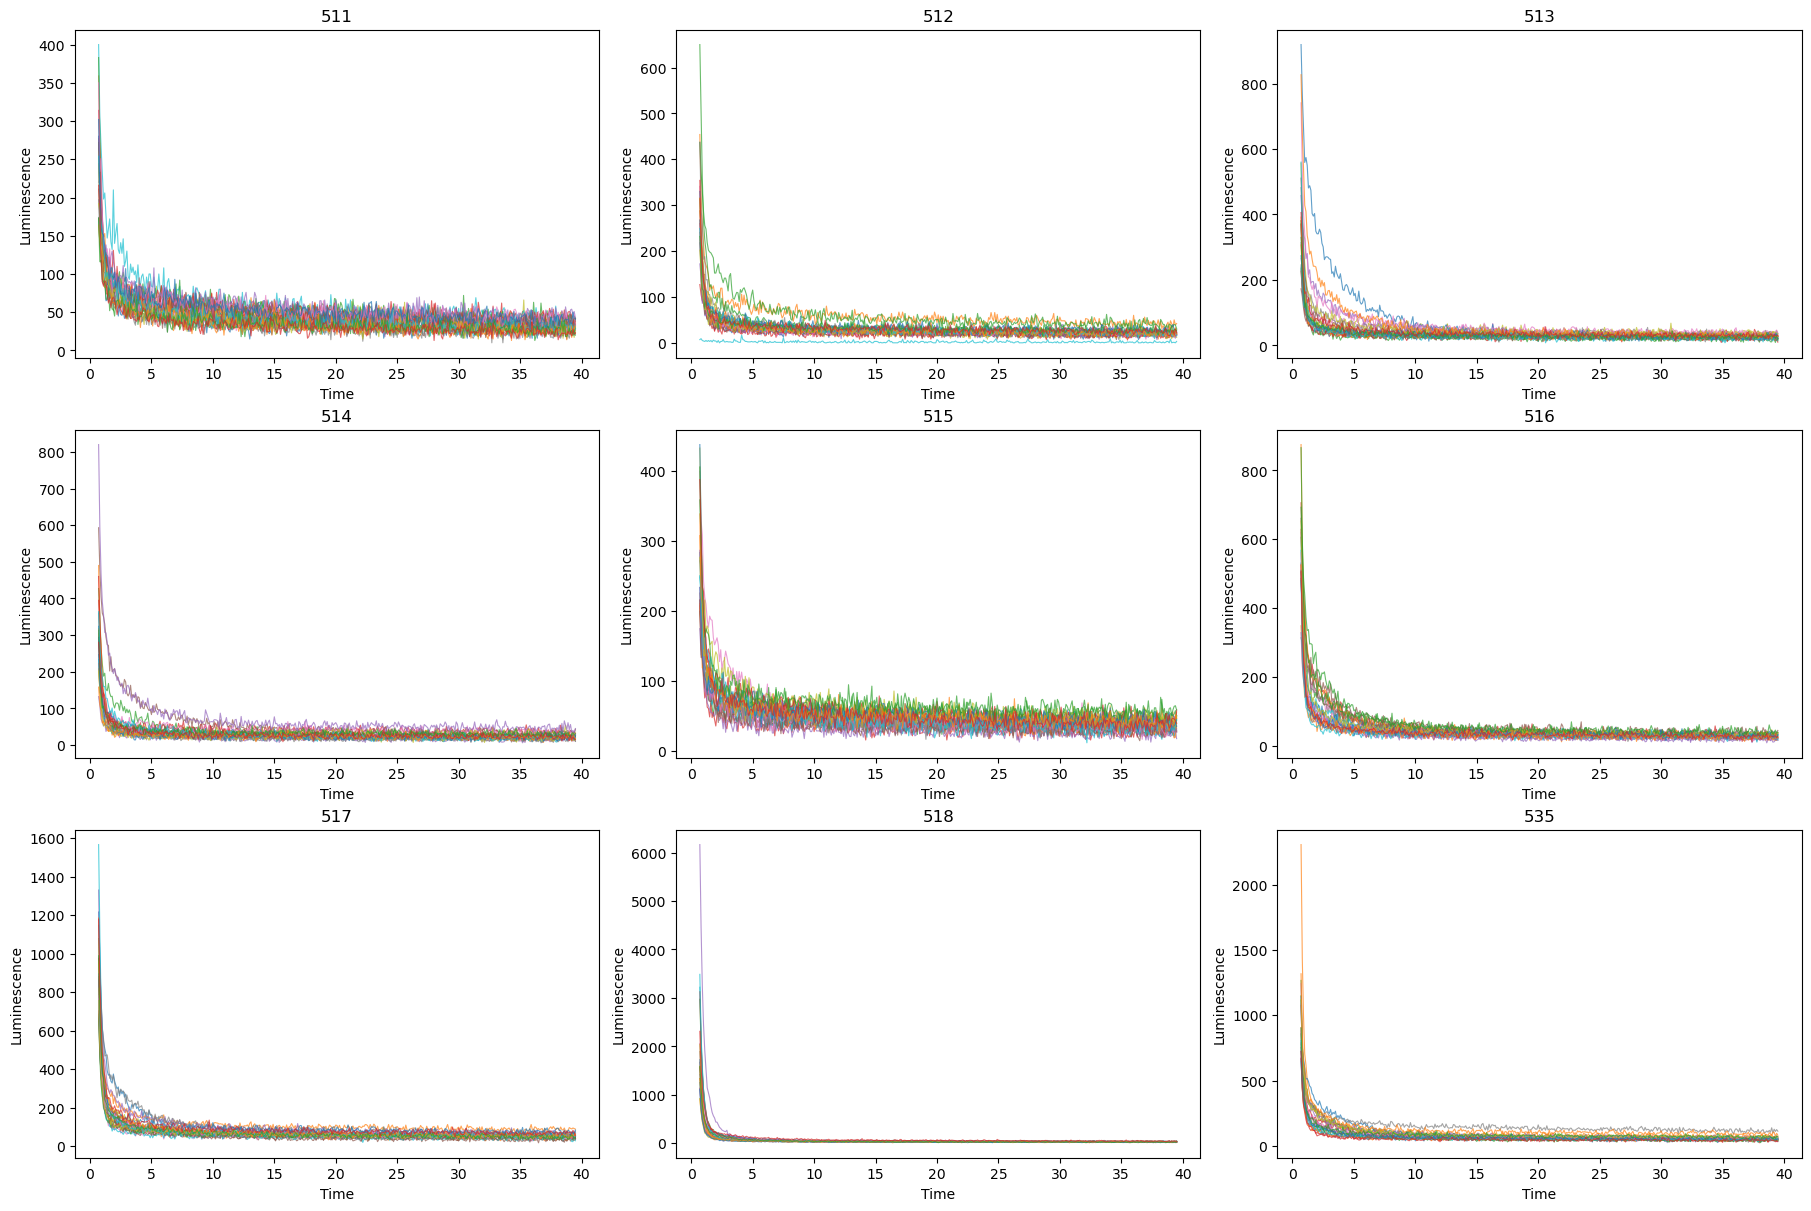

✓ processed (cropped) data saved to output\processed_data_ori.pkl


In [12]:
import os, pickle
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# Paths
# ------------------------------------------------------------------
excel_path  = 'data/data.xlsx'
output_dir  = 'output'
pickle_file = os.path.join(output_dir, 'processed_data_ori.pkl')
os.makedirs(output_dir, exist_ok=True)

# ------------------------------------------------------------------
# Load every sheet, clean, crop, store
# ------------------------------------------------------------------
if not os.path.exists(excel_path):
    print(f"File {excel_path} not found. Current directory contents:")
    for root, _, files in os.walk('.'):
        for f in files:
            print(os.path.join(root, f))
    raise SystemExit

sheets  = pd.read_excel(excel_path, sheet_name=None, header=None)
cleaned = {}

for name, df in sheets.items():
    df_t = (
        df.drop(index=0)          # drop the textual first row
          .reset_index(drop=True)
          .T                      # transpose
    )
    df_t.columns = df_t.iloc[0]   # promote first transposed row to header
    df_t = df_t.drop(index=0).reset_index(drop=True)

    # ensure numeric dtypes
    df_t = df_t.apply(pd.to_numeric, errors='ignore')

    # -------- CROP: keep Time_index in [7, 395] -------------------
    mask  = (df_t['Time_index'] >= 7) & (df_t['Time_index'] <= 395)
    df_t  = df_t.loc[mask].reset_index(drop=True)

    cleaned[name] = df_t

# ------------------------------------------------------------------
# Quick-look plot: 3 × 3 grid
# ------------------------------------------------------------------
fig, axes = plt.subplots(3, 3, figsize=(18, 12), layout='constrained')
axes = axes.ravel()

for ax, (name, df_t) in zip(axes, cleaned.items()):
    time    = df_t['Time'].astype(float).values
    slices  = df_t.drop(columns=['Time_index', 'Time'])

    ax.plot(time, slices.values, lw=0.8, alpha=0.7)
    ax.set_title(name)
    ax.set_xlabel('Time')
    ax.set_ylabel('Luminescence')

# remove unused panes if < 9 sheets
for ax in axes[len(cleaned):]:
    ax.remove()

plt.show()

# ------------------------------------------------------------------
# Pickle the cropped data
# ------------------------------------------------------------------
with open(pickle_file, 'wb') as f:
    pickle.dump(cleaned, f)

print(f'✓ processed (cropped) data saved to {pickle_file}')


# Single slice analysis

(389, 2)


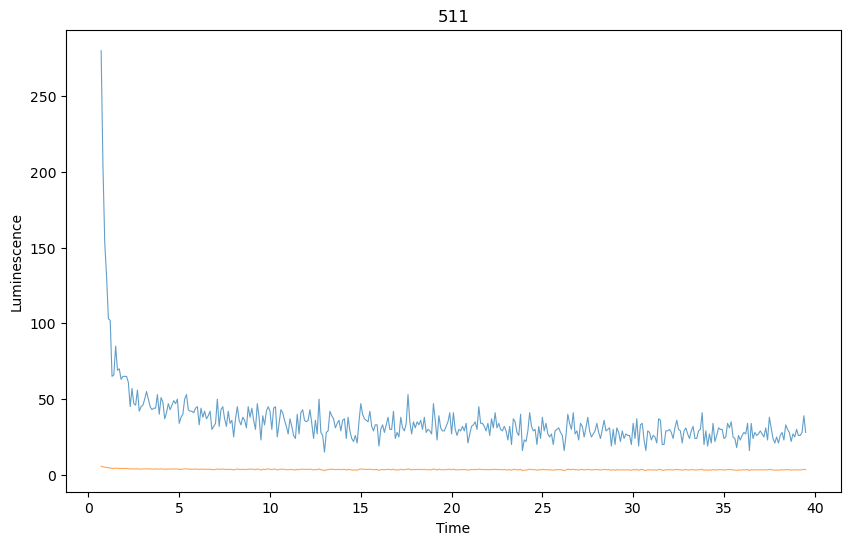

In [11]:
import pandas as pd
import numpy as np

df  = pd.read_excel(excel_path, sheet_name='511', header=None)
df_t = (
    df.drop(index=0)          # drop the textual first row
        .reset_index(drop=True)
        .T                      # transpose
)
df_t.columns = df_t.iloc[0]   # promote first transposed row to header
df_t = df_t.drop(index=0).reset_index(drop=True)

# ensure numeric dtypes
df_t = df_t.apply(pd.to_numeric, errors='ignore')

# -------- CROP: keep Time_index in [7, 395] -------------------
mask  = (df_t['Time_index'] >= 7) & (df_t['Time_index'] <= 395)
df_t  = df_t.loc[mask].reset_index(drop=True)

# get the second and third columns a s a ndarray

slices = df_t.iloc[:, 1:3].values
print(slices.shape)  # (389, 2)

# plot the slices
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(slices[:, 0], slices[:, 1], lw=0.8, alpha=0.7)
# plot the logarithm of the slices
plt.plot(slices[:, 0], np.log(slices[:, 1]), lw=0.8, alpha=0.7)

plt.title('511')
plt.xlabel('Time')
plt.ylabel('Luminescence')
plt.show()


# 发现数据方差太大了影响分析，先进行对数变换，保存变换后的数据

Sheet 512: dropped 1 low-count slice(s)


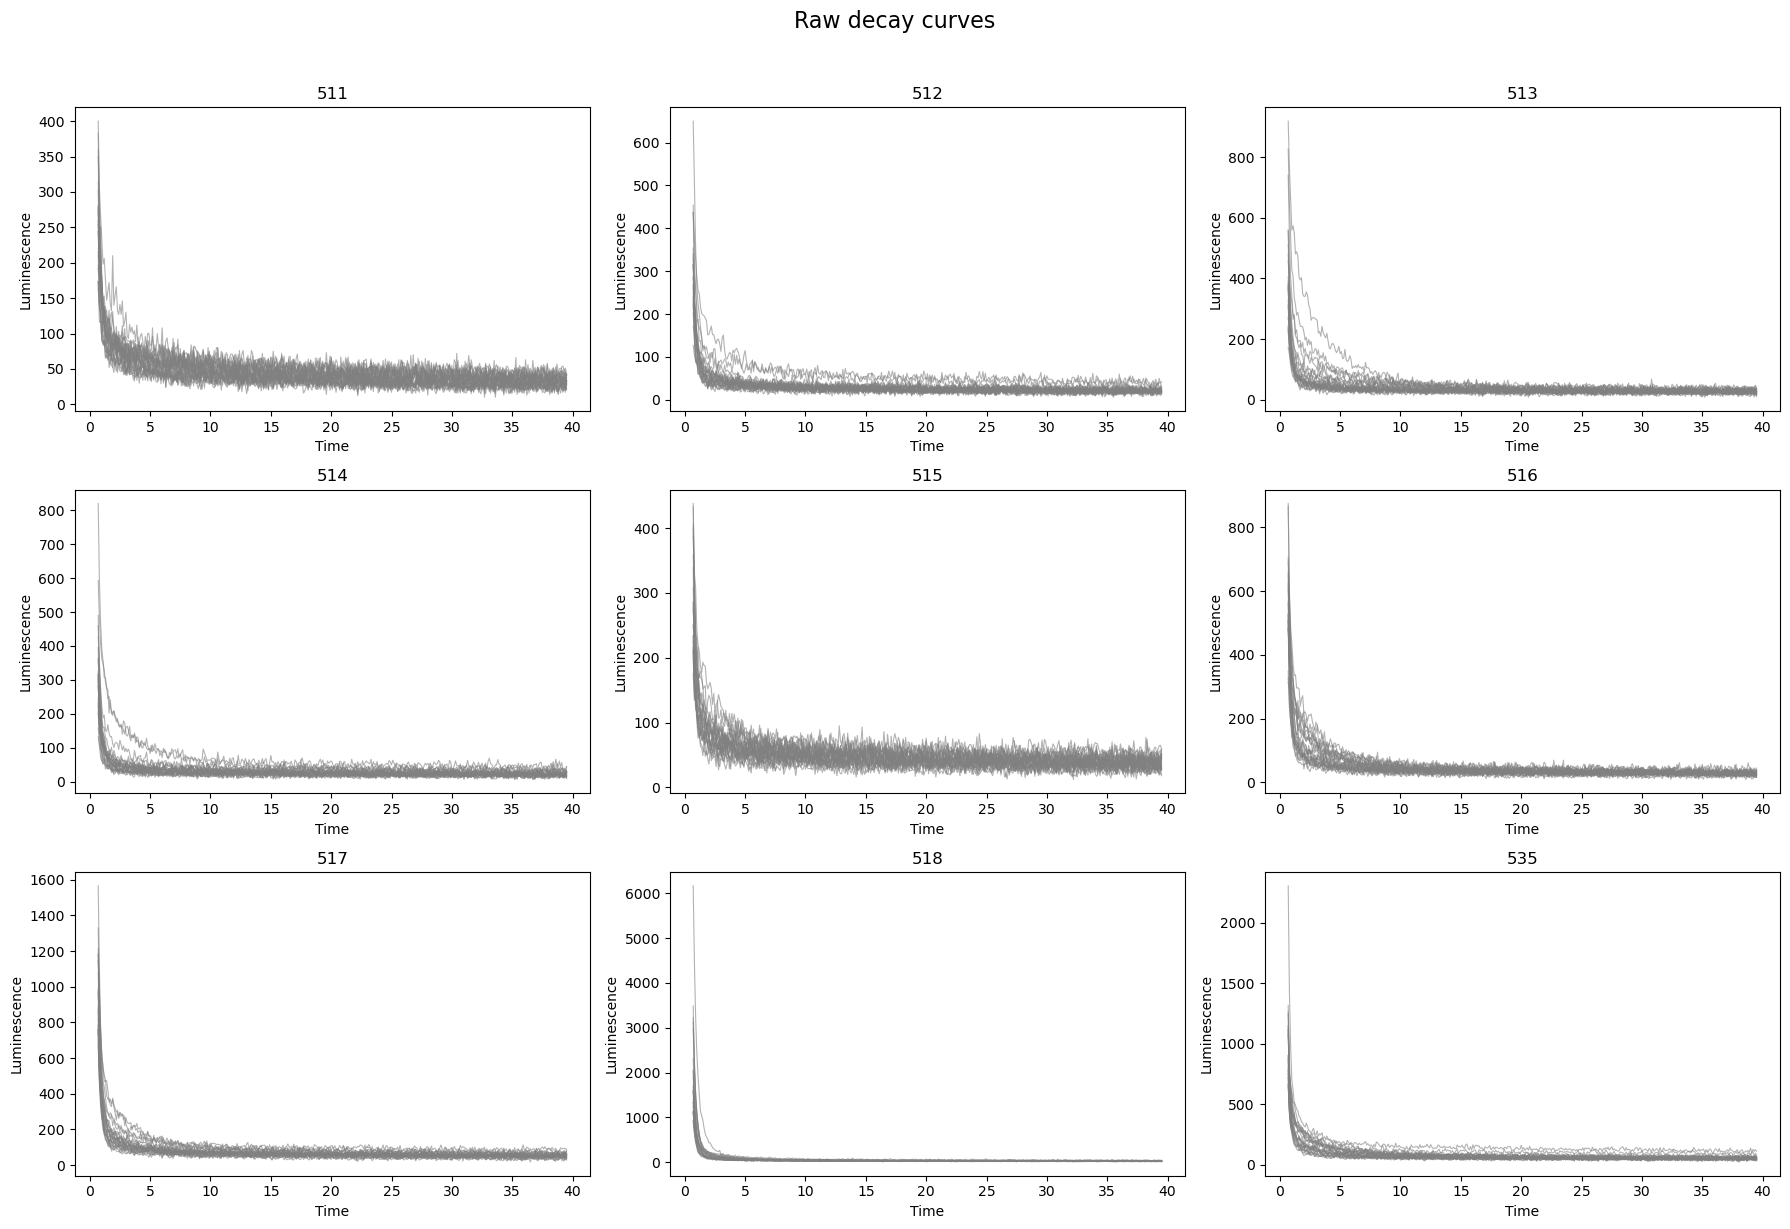

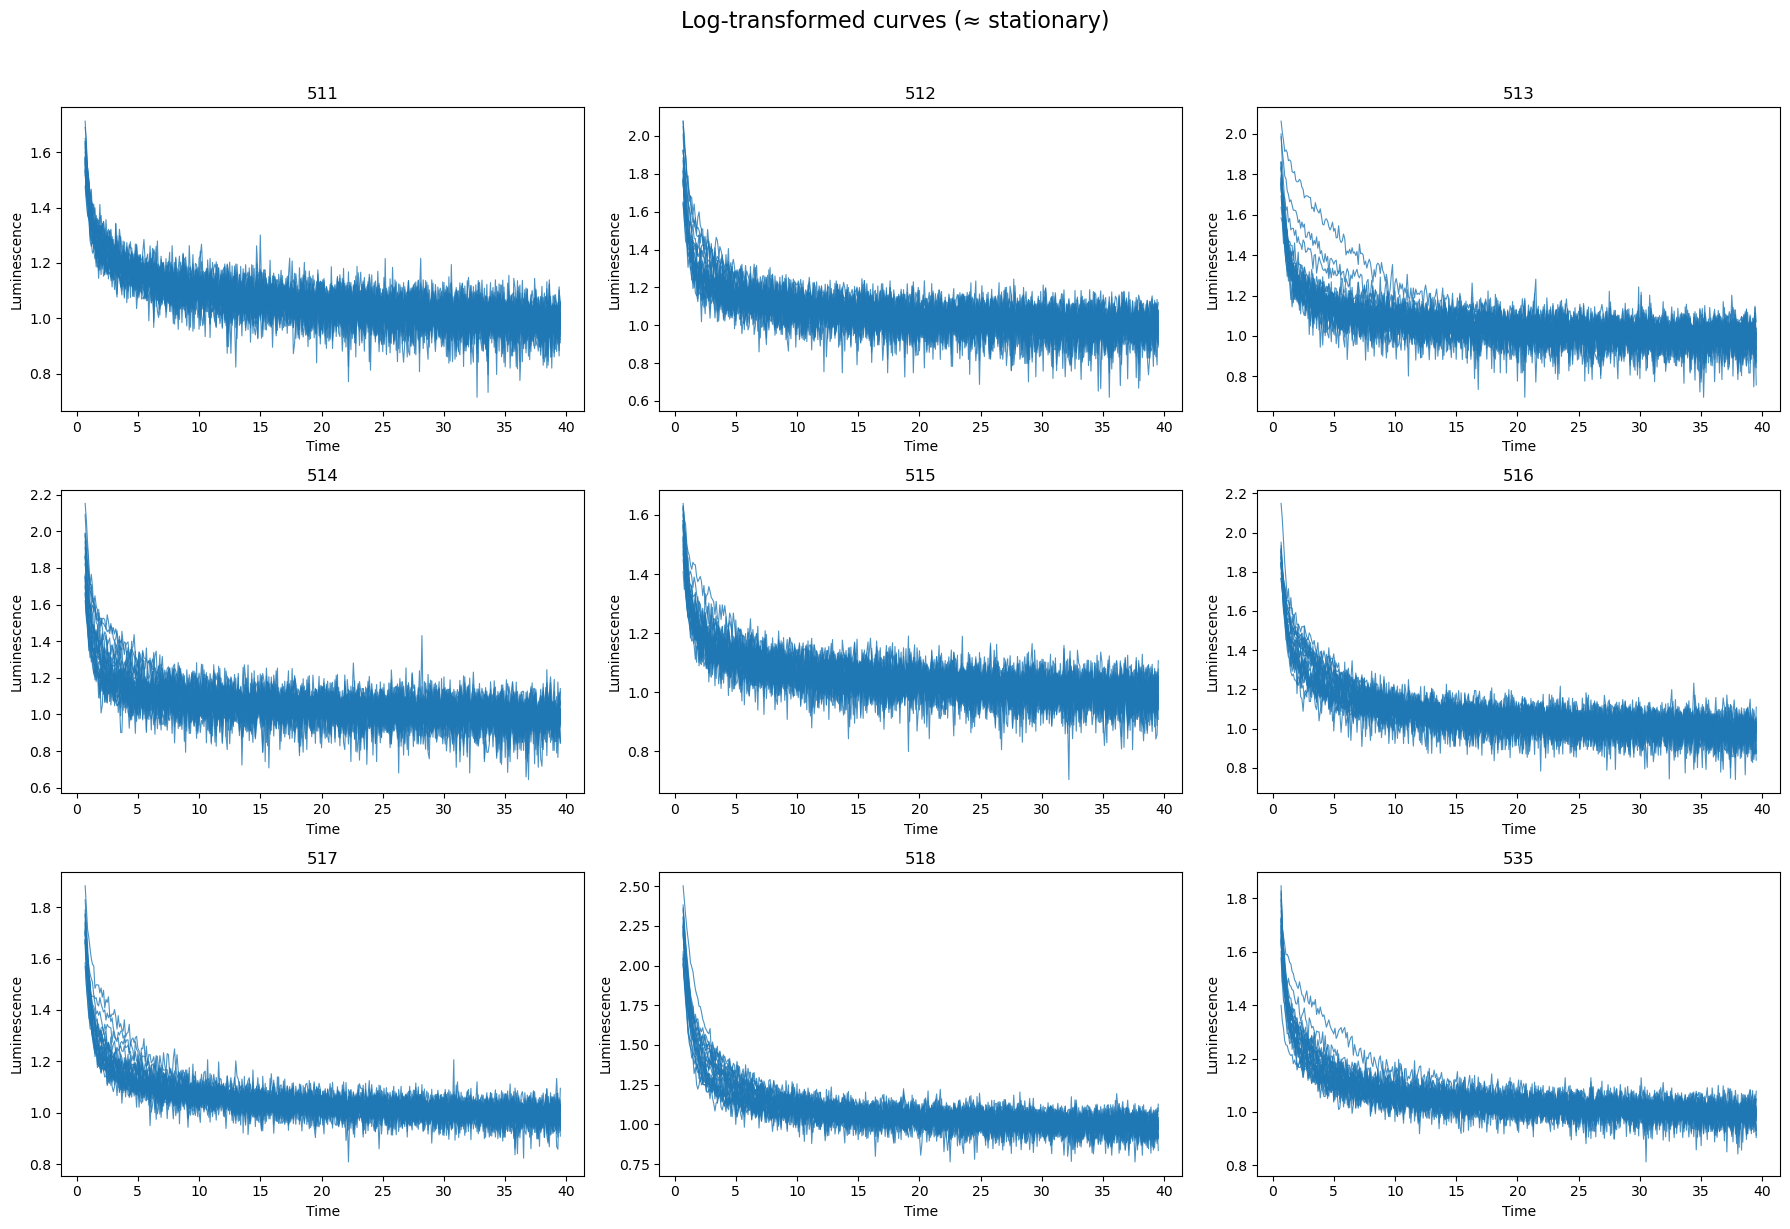

✓ raw & log-transformed data saved to output\processed_data.pkl


In [22]:
import os, pickle, numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# Paths
# ------------------------------------------------------------------
excel_path  = 'data/data.xlsx'
output_dir  = 'output'
pickle_file = os.path.join(output_dir, 'processed_data.pkl')
os.makedirs(output_dir, exist_ok=True)

# ------------------------------------------------------------------
# 1.  Load sheets, clean, crop 7 ≤ Time_index ≤ 395
# ------------------------------------------------------------------
if not os.path.exists(excel_path):
    raise FileNotFoundError(f'{excel_path} not found!')

sheets   = pd.read_excel(excel_path, sheet_name=None, header=None)


# raw_dict = {}          # original counts
# log_dict = {}          # log-transformed

# for name, df in sheets.items():
#     df_t = (
#         df.drop(index=0).reset_index(drop=True).T
#     )
#     df_t.columns = df_t.iloc[0]
#     df_t = df_t.drop(index=0).reset_index(drop=True)
#     df_t = df_t.apply(pd.to_numeric, errors='ignore')

#     mask  = (df_t['Time_index'] >= 7) & (df_t['Time_index'] <= 395)
#     df_t  = df_t.loc[mask].reset_index(drop=True)

#     # ── keep a copy of the raw counts ────────────────────────────
#     raw_dict[name] = df_t.copy()

#     # ── log10 transform the slice columns only ───────────────────
#     slice_cols = df_t.columns.difference(['Time_index', 'Time'])
#     df_log = df_t.copy()
#     df_log[slice_cols] = np.log10(df_log[slice_cols] + 1e-9)  # tiny offset avoids log(0)
#     log_dict[name] = df_log


raw_dict, log_dict = {}, {}

for name, df in sheets.items():
    # ── tidy & crop rows ──────────────────────────────────────────
    df_t = (
        df.drop(index=0).reset_index(drop=True).T
    )
    df_t.columns = df_t.iloc[0]
    df_t = df_t.drop(index=0).reset_index(drop=True)
    df_t = df_t.apply(pd.to_numeric, errors='ignore')

    mask  = (df_t['Time_index'] >= 7) & (df_t['Time_index'] <= 395)
    df_t  = df_t.loc[mask].reset_index(drop=True)

    # ── log10 transform the slice columns only ───────────────────
    slice_cols = df_t.columns.difference(['Time_index', 'Time'])
    df_log = df_t.copy()
    df_log[slice_cols] = np.log10(df_log[slice_cols] + 1e-9)
    # df_log[slice_cols] = np.log(df_log[slice_cols] + 1e-9)   # base-e log

    # ── filter: keep slices whose entire log curve ≥ 0 ───────────
    good_cols = [
        c for c in slice_cols
        if (df_log[c] >= 0).all()
    ]
    n_dropped = len(slice_cols) - len(good_cols)
    if n_dropped:
        print(f'Sheet {name}: dropped {n_dropped} low-count slice(s)')

    # ── NORMALISE each good slice by mean of its last 100 values ─
    for col in good_cols:
        tail_mean = df_log[col].iloc[-100:].mean()  # fewer rows → uses all
        if tail_mean != 0:                          # guard against zero just in case
            df_log[col] /= tail_mean

    keep_cols = ['Time_index', 'Time'] + good_cols
    raw_dict[name] = df_t[keep_cols].copy()
    log_dict[name] = df_log[keep_cols].copy()



# # crop the log_dict for time <=150
# for name, df in log_dict.items():
#     mask  = (df['Time_index'] <= 200)
#     df_t  = df.loc[mask].reset_index(drop=True)
#     log_dict[name] = df_t.copy()


# ------------------------------------------------------------------
# 2.  Quick-look plot : raw vs. log
# ------------------------------------------------------------------
def plot_grid(data_dict, title_suffix, line_kw, colour='C0'):
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    axes = axes.ravel()

    for ax, (name, df) in zip(axes, data_dict.items()):
        t   = df['Time'].astype(float).values
        y   = df.drop(columns=['Time_index', 'Time']).values

        ax.plot(t, y, **line_kw, color=colour)
        ax.set_title(name)
        ax.set_xlabel('Time')
        ax.set_ylabel('Luminescence')

    for ax in axes[len(data_dict):]:
        ax.axis('off')

    fig.suptitle(title_suffix, fontsize=16, y=1.02)
    fig.tight_layout()
    return fig

plot_grid(raw_dict, 'Raw decay curves', dict(lw=0.8, alpha=0.6), colour='grey')
plot_grid(log_dict, 'Log-transformed curves (≈ stationary)', dict(lw=0.8, alpha=0.8))
plt.show()

# ------------------------------------------------------------------
# 3.  Pickle both data sets
# ------------------------------------------------------------------
with open(pickle_file, 'wb') as f:
    pickle.dump(log_dict, f)

print(f'✓ raw & log-transformed data saved to {pickle_file}')


# 使用AIC的局部最低点找出NMF的源的最佳数量，避免欠拟合和过拟合

Combined data matrix shape: (215, 389)
Optimal rank (N) from AIC: 2


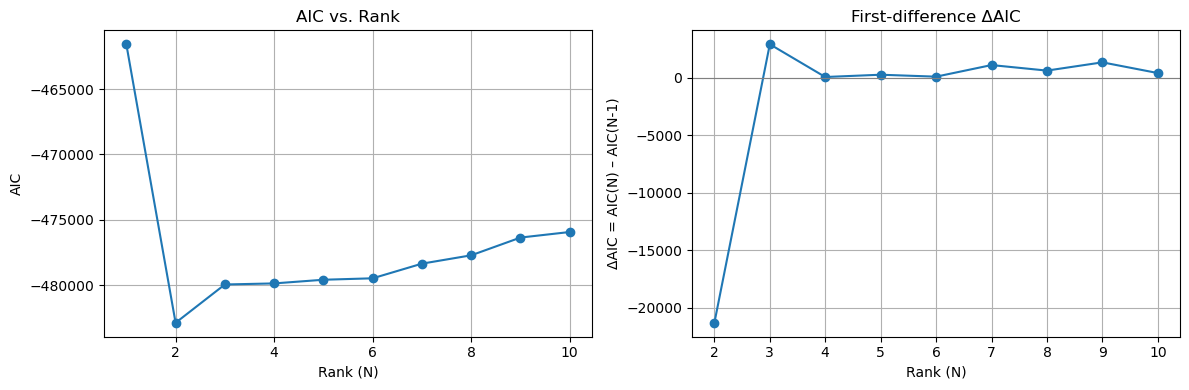

In [23]:
import os, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from matplotlib.cm import get_cmap

# ------------------------------------------------------------
# Load the processed, cropped data dict produced earlier
# ------------------------------------------------------------
pickle_path = 'output/processed_data.pkl'
if not os.path.exists(pickle_path):
    raise FileNotFoundError(f"Processed data not found at {pickle_path}")

with open(pickle_path, 'rb') as f:
    data_dict = pickle.load(f)

# ------------------------------------------------------------
# Build the big data matrix X  (rows = slices, cols = time-bins)
# ------------------------------------------------------------
X_list, sample_tag = [], []
time_axis = None

for name, df in data_dict.items():
    if time_axis is None:
        time_axis = df['Time'].to_numpy(dtype=float)

    slice_cols  = df.columns.difference(['Time_index', 'Time'])
    mat         = df[slice_cols].to_numpy(dtype=float)      # (n_time, n_slices)
    X_list.append(mat.T)                                    # -> (n_slices, n_time)
    sample_tag.extend([name] * mat.shape[1])

X           = np.vstack(X_list)
n_slices, n_time = X.shape
print("Combined data matrix shape:", X.shape)

# ------------------------------------------------------------
# Helper: AIC
# ------------------------------------------------------------
def compute_aic(rss, r, m, n):
    k      = r * (m + n)           # free parameters in W (m×r) and H (r×n)
    n_obs  = m * n
    return 2 * k + n_obs * np.log(rss / n_obs)

# ------------------------------------------------------------
# 1. Sweep ranks and compute AIC
# ------------------------------------------------------------
max_r    = min(10, n_time)
aic_vals = []

for r in range(1, max_r + 1):
    nmf = NMF(n_components=r, init='nndsvda', solver='mu',
              max_iter=2000, random_state=0)
    W = nmf.fit_transform(X)
    H = nmf.components_
    rss = np.square(X - W @ H).sum()
    aic_vals.append(compute_aic(rss, r, n_slices, n_time))

aic_vals  = np.array(aic_vals)
delta_aic = np.diff(aic_vals)          # first difference, length = max_r-1
opt_r     = int(np.argmin(aic_vals) + 1)
print("Optimal rank (N) from AIC:", opt_r)

# ------------------------------------------------------------
# Plot AIC and ΔAIC
# ------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# AIC curve
ax1.plot(range(1, max_r + 1), aic_vals, marker='o')
ax1.set_xlabel('Rank (N)')
ax1.set_ylabel('AIC')
ax1.set_title('AIC vs. Rank')
ax1.grid(True)

# ΔAIC curve (starts at N=2)
ax2.plot(range(2, max_r + 1), delta_aic, marker='o')
ax2.set_xlabel('Rank (N)')
ax2.set_ylabel('ΔAIC = AIC(N) – AIC(N-1)')
ax2.set_title('First-difference ΔAIC')
ax2.axhline(0, color='gray', lw=0.8)
ax2.grid(True)

plt.tight_layout()
plt.show()


min row-sum 0.7804035022814637 max row-sum 1.0


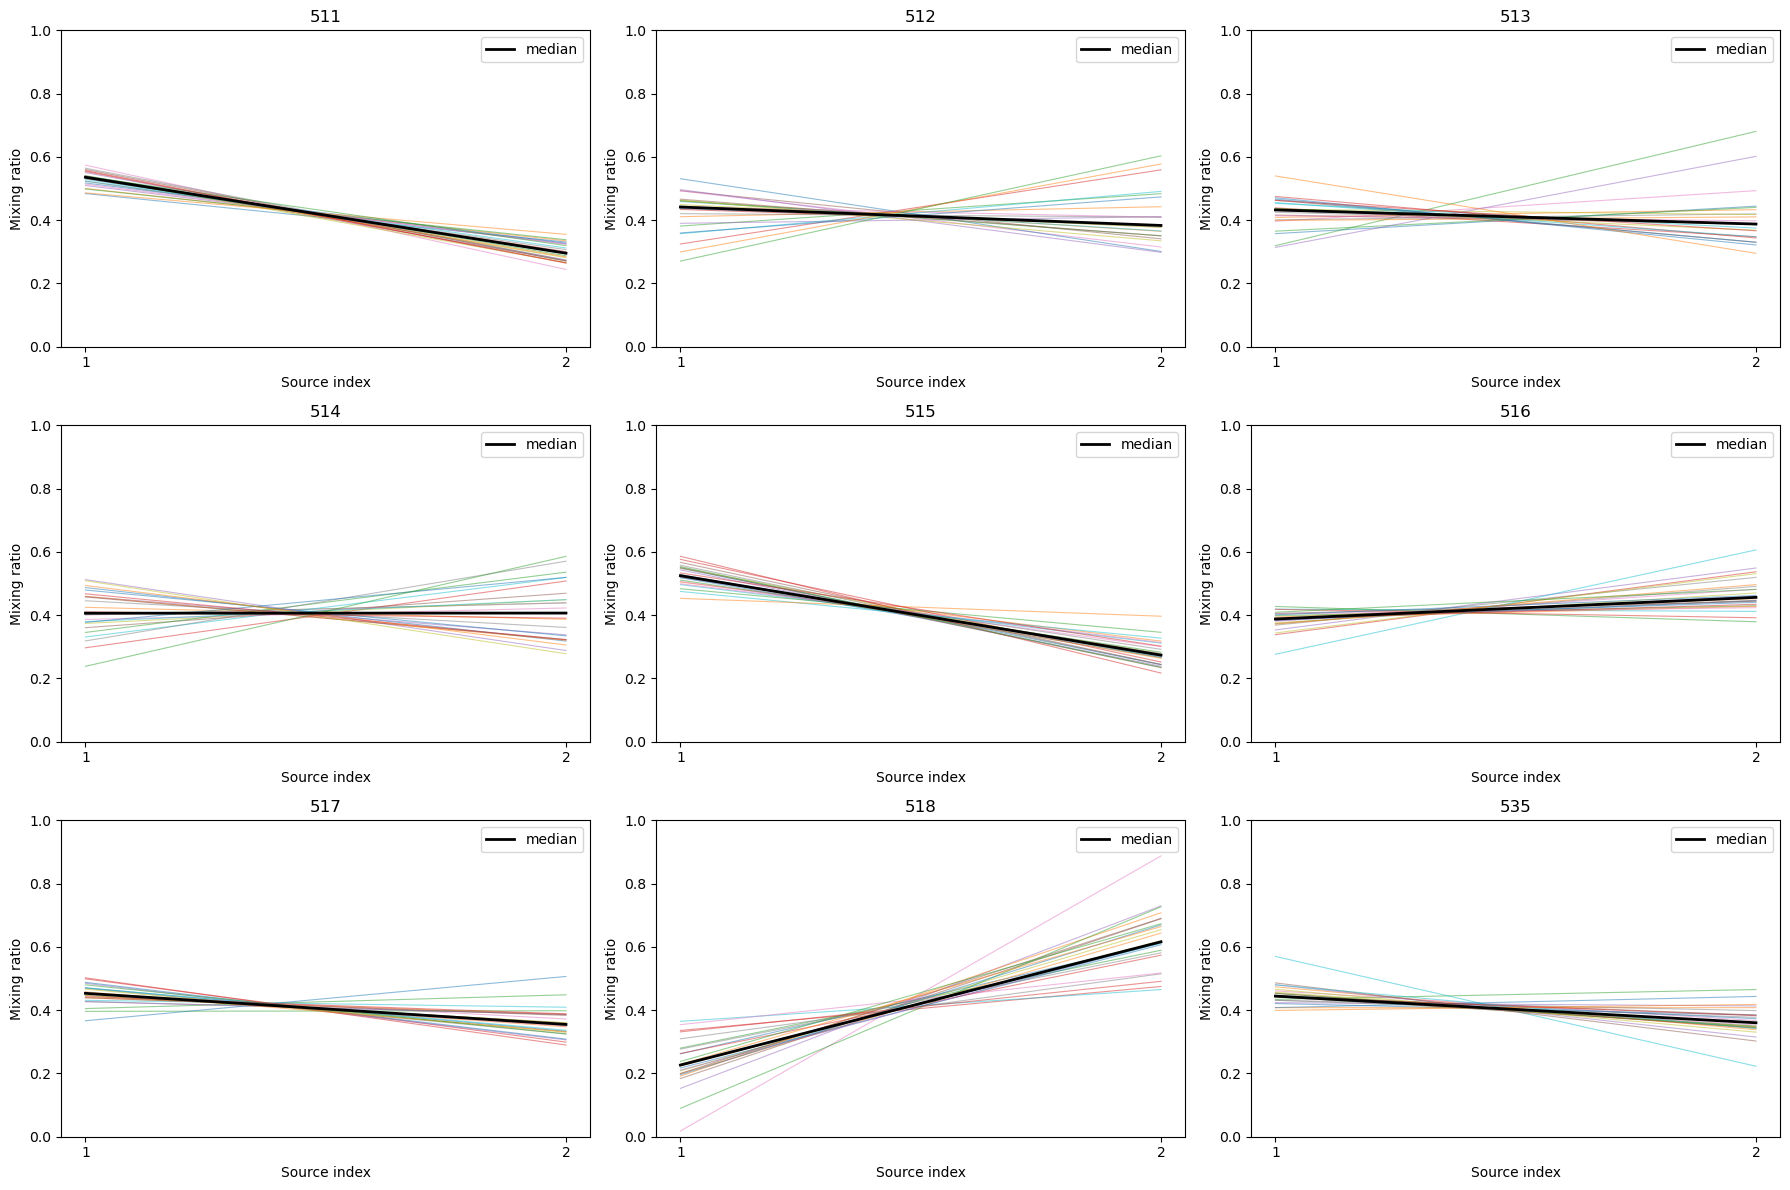

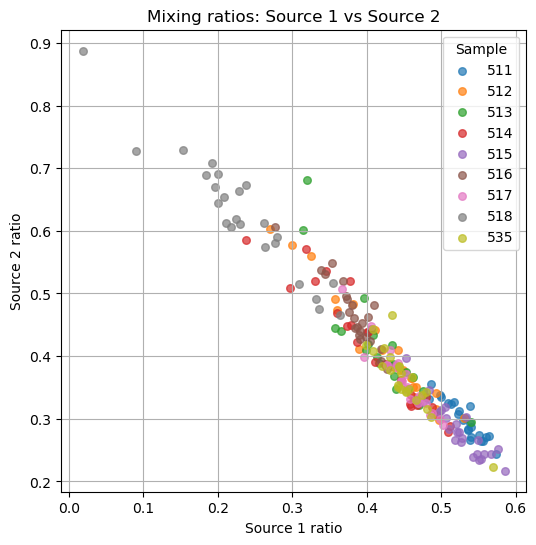

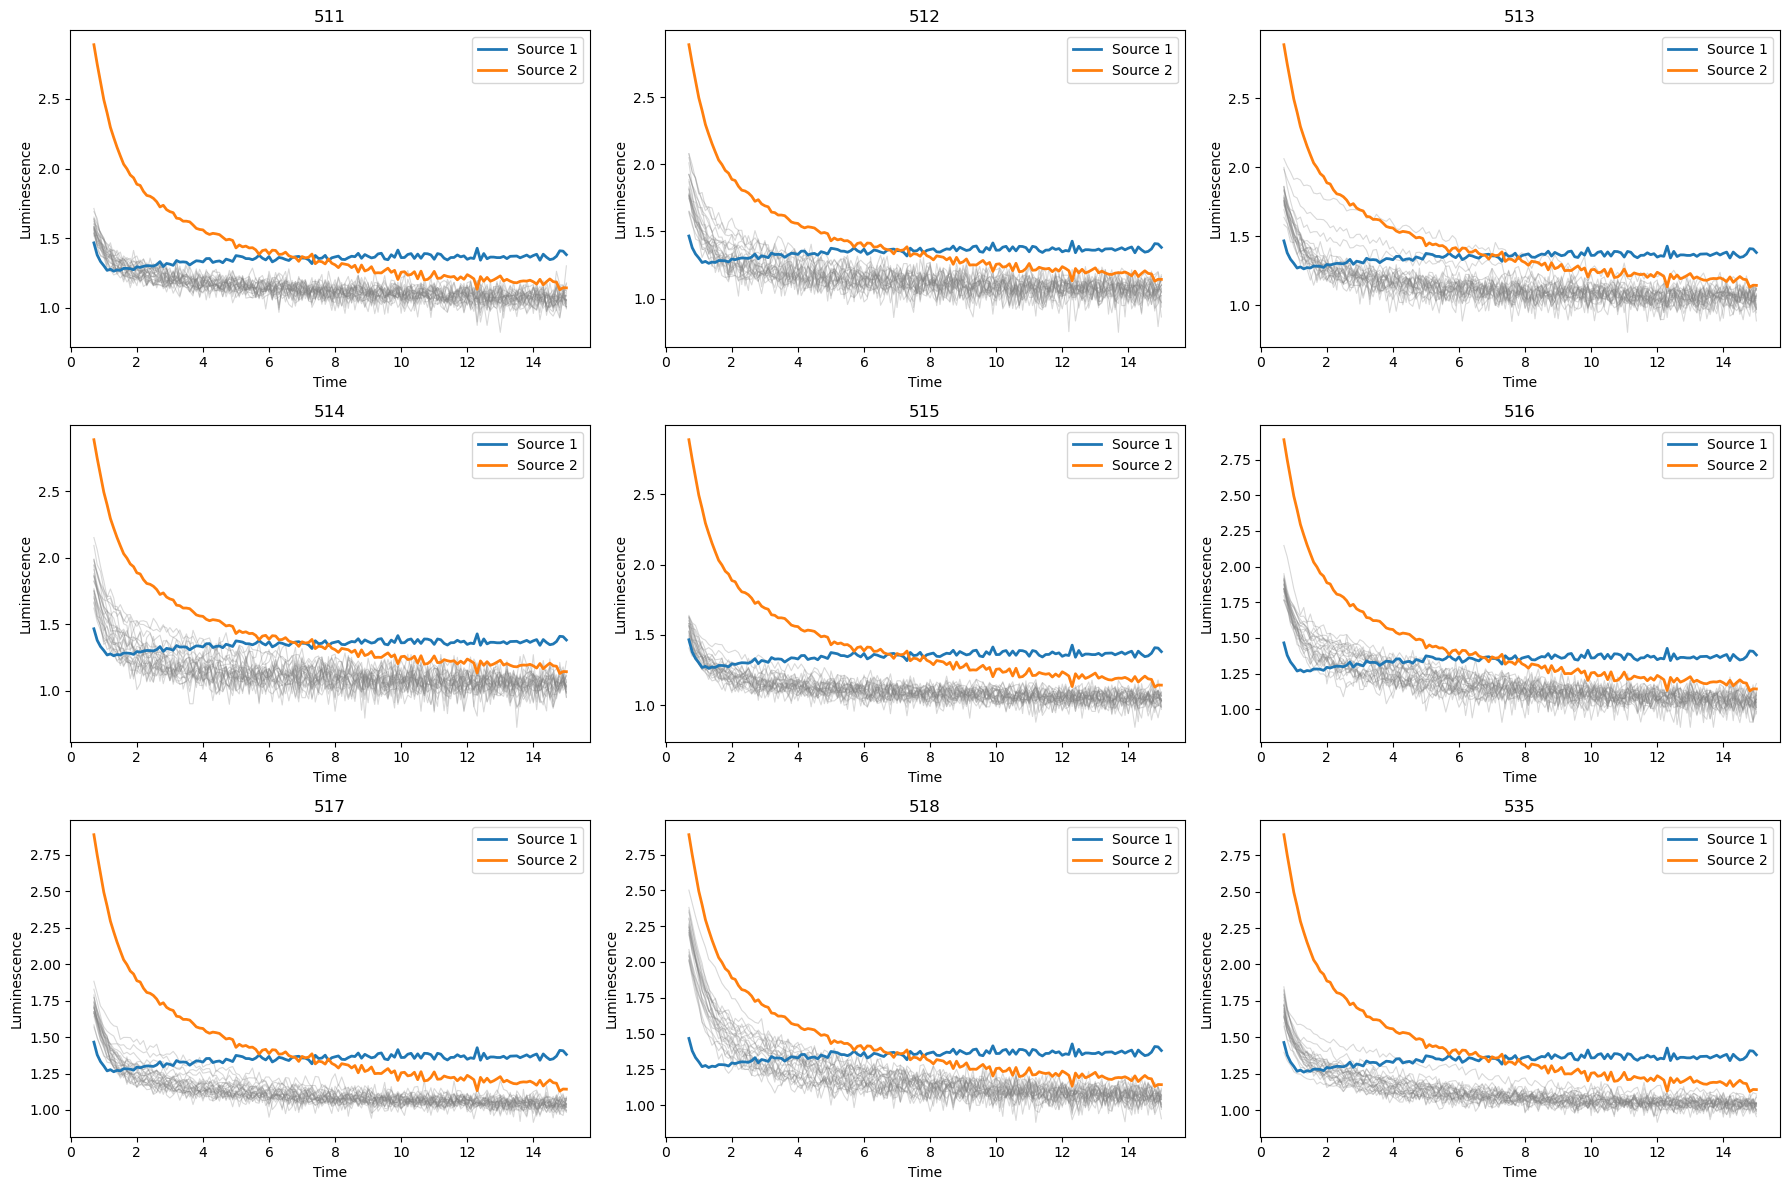

In [18]:
import numpy as np
import unicodedata
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
# from matplotlib.cm import get_cmap
from matplotlib import colormaps
from scipy.stats import zscore




# def nmf_sum_leq_one(X, r=2, max_iter=1000, tol=1e-4,
#                     random_state=0):
#     rng = np.random.default_rng(random_state)
#     m, n = X.shape
#     W = rng.random((m, r)) + 1e-6
#     H = rng.random((r, n)) + 1e-6

#     for it in range(max_iter):
#         WH = W @ H + 1e-12

#         # MU updates (β = 2, Frobenius)
#         W *= (X @ H.T) / (WH @ H.T)
#         H *= (W.T @ X) / (W.T @ WH)

#         # -------- projection: row-sum ≤ 1 ---------
#         row_sum = W.sum(axis=1)
#         for i, rs in enumerate(row_sum):
#             if rs > 1.0:
#                 W[i, :] /= rs    # renormalise that row

#         # convergence every 50 iters
#         if it % 50 == 0:
#             err = np.linalg.norm(X - W @ H) / np.linalg.norm(X)
#             if err < tol:
#                 break

#     return W, H






import numpy as np

def mf_sum_leq_one(X, r=2, max_iter=2000, tol=1e-5,
                   random_state=0, verbose=False):
    """
    Matrix factorisation  X ≈ W @ H
    W : (m × r)   – may be *negative*, but each row sum ≤ 1
    H : (r × n)   – unconstrained (can be negative)

    Parameters
    ----------
    X : array_like, shape (m, n)
        Data matrix (slices × time)
    r : int
        Rank of factorisation (= number of sources)
    max_iter : int
        Maximum ALS iterations
    tol : float
        Relative Frobenius‑norm tolerance for convergence
    random_state : int or None
        Seed for reproducibility
    """
    rng = np.random.default_rng(random_state)
    m, n = X.shape

    # --- initialise ----------------------------------------------------------------
    W = rng.normal(scale=0.01, size=(m, r))     # small positives & negatives
    H = rng.normal(scale=0.01, size=(r, n))

    def project_rowsum_leq_one(A):
        """Shift every row so its sum ≤ 1 (can give negatives)."""
        rs = A.sum(axis=1)
        mask = rs > 1
        # subtract the excess evenly from that row
        A[mask] -= (rs[mask] - 1)[:, None] / r
        return A

    W = project_rowsum_leq_one(W)

    # --- ALS loop -------------------------------------------------------------------
    last_err = np.inf
    for it in range(max_iter):

        # (1) fix W, solve least‑squares for H
        H = np.linalg.lstsq(W, X, rcond=None)[0]

        # (2) fix H, solve least‑squares for W
        W = (X @ H.T) @ np.linalg.inv(H @ H.T)

        # enforce row‑sum ≤ 1
        W = project_rowsum_leq_one(W)

        # --- convergence check every 20 iters --------------------------------------
        if it % 20 == 0:
            err = np.linalg.norm(X - W @ H, ord='fro') / np.linalg.norm(X, ord='fro')
            if verbose:
                print(f"iter {it:4d}  rel‑err = {err:.4e}")
            if abs(last_err - err) < tol:
                break
            last_err = err

    return W, H








# ------------------------------------------------------------
# Helper to canonicalise a sample label
# ------------------------------------------------------------
def canon(s):
    s = str(s).strip()                 # drop leading/trailing spaces
    s = unicodedata.normalize('NFKC', s)  # normalise unicode width
    return s

# ------------------------------------------------------------
# 1. Canonicalise sample_tag immediately after you build it
# ------------------------------------------------------------
sample_tag = np.array([canon(t) for t in sample_tag])

# 2. Unique list for plotting (already canonical)
unique_samples = sorted(set(sample_tag))

# ------------------------------------------------------------
# 2. Fit NMF (rank = 3)
# ------------------------------------------------------------
# opt_r   = 2
# nmf_opt = NMF(n_components=opt_r, init='nndsvda', solver='mu',
#               max_iter=2000, random_state=1)
# W_opt = nmf_opt.fit_transform(X)
# W_norm = W_opt / W_opt.sum(axis=1, keepdims=True)

# # print the shape of W_norm
# print("Shape of W_norm:", W_norm.shape)  # (n_slices, n_sources)
# print("Shape of H_opt:", nmf_opt.components_.shape)  # (n_sources, n_time)



opt_r = 2
W_opt, H_opt = nmf_sum_leq_one(X, r=opt_r, max_iter=2000,
                               tol=1e-4, random_state=1)

# row-sums are already ≤ 1, so no need for extra normalisation
row_sums = W_opt.sum(axis=1)
print("min row-sum", row_sums.min(), "max row-sum", row_sums.max())  # ≤ 1

# ------------------------------------------------------------
# 3. Mixing-ratio curves, 3×3 grid
# ------------------------------------------------------------
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.ravel()

# cmap = get_cmap('tab10')
cmap = colormaps['tab10']
col_dict = {s: cmap(i % 10) for i, s in enumerate(unique_samples)}

for ax, sample in zip(axes, unique_samples):
    idx = np.flatnonzero(sample_tag == sample)   # same as where()[0]

    if idx.size == 0:            # nothing matched ⇒ blank this pane
        ax.axis('off')
        continue

    w_sample = W_opt[idx]       # (#slices_in_sample × 3)
    x = np.arange(1, opt_r + 1)

    ax.plot(x, w_sample.T, lw=0.8, alpha=0.5)
    ax.plot(x, np.median(w_sample, axis=0),
            lw=2, color='black', label='median')
    # only show x ticks at rank=1,2,3
    ax.set_xticks(x)
    # ax.set_xticklabels([f'Source {i}' for i in x])
    ax.set(title=sample, xlabel='Source index',
           ylabel='Mixing ratio', ylim=(0, 1))
    ax.legend()

# any spare subplots
for ax in axes[len(unique_samples):]:
    ax.axis('off')

fig.tight_layout()
plt.show()

# ------------------------------------------------------------
# 4. Scatter of source-1 vs source-2 fractions
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 6))

for sample in unique_samples:
    idx = np.flatnonzero(sample_tag == sample)
    # ax.scatter(W_norm[idx, 0], W_norm[idx, 1],
    #            label=sample, alpha=0.7, s=30,
    #            color=col_dict[sample])
    ax.scatter(W_opt[idx, 0], W_opt[idx, 1],
               label=sample, alpha=0.7, s=30,
               color=col_dict[sample])
    
    # ax.scatter(zscore(W_opt[idx, 0]), zscore(W_opt[idx, 1]),
    #            label=sample, alpha=0.7, s=30,
    #            color=col_dict[sample])

ax.set(xlabel='Source 1 ratio', ylabel='Source 2 ratio',
       title='Mixing ratios: Source 1 vs Source 2'
) 
#        xlim=(0, 1), ylim=(0, 1)
ax.legend(title='Sample')
ax.grid(True)
plt.show()




# ------------------------------------------------------------
# 5.  “Sources-vs-Slices” diagnostic: 3 × 3 grid
# ------------------------------------------------------------
# H_opt = nmf_opt.components_          # shape (3, n_time)
time  = time_axis                    # same x-axis for all

src_cmap   = plt.colormaps['tab10']  # any qualitative map you like
src_colors = [src_cmap(i) for i in range(3)]

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.ravel()

for ax, sample in zip(axes, unique_samples):
    idx = np.flatnonzero(sample_tag == sample)      # slices for this sample
    if idx.size == 0:
        ax.axis('off')
        continue

    # --- grey slice curves ----------------------------------
    ax.plot(time, X[idx].T, color='grey', alpha=0.3, lw=0.8)

    # --- the three source signatures ------------------------
    for k, (src, col) in enumerate(zip(H_opt, src_colors), start=1):
        ax.plot(time, src, color=col, lw=2,
                label=f'Source {k}')

    ax.set(title=sample, xlabel='Time', ylabel='Luminescence')
    ax.legend()

# hide unused panes if < 9 samples
for ax in axes[len(unique_samples):]:
    ax.axis('off')

fig.tight_layout()
plt.show()

Shape of W_norm: (215, 3)
Shape of H_opt: (3, 389)


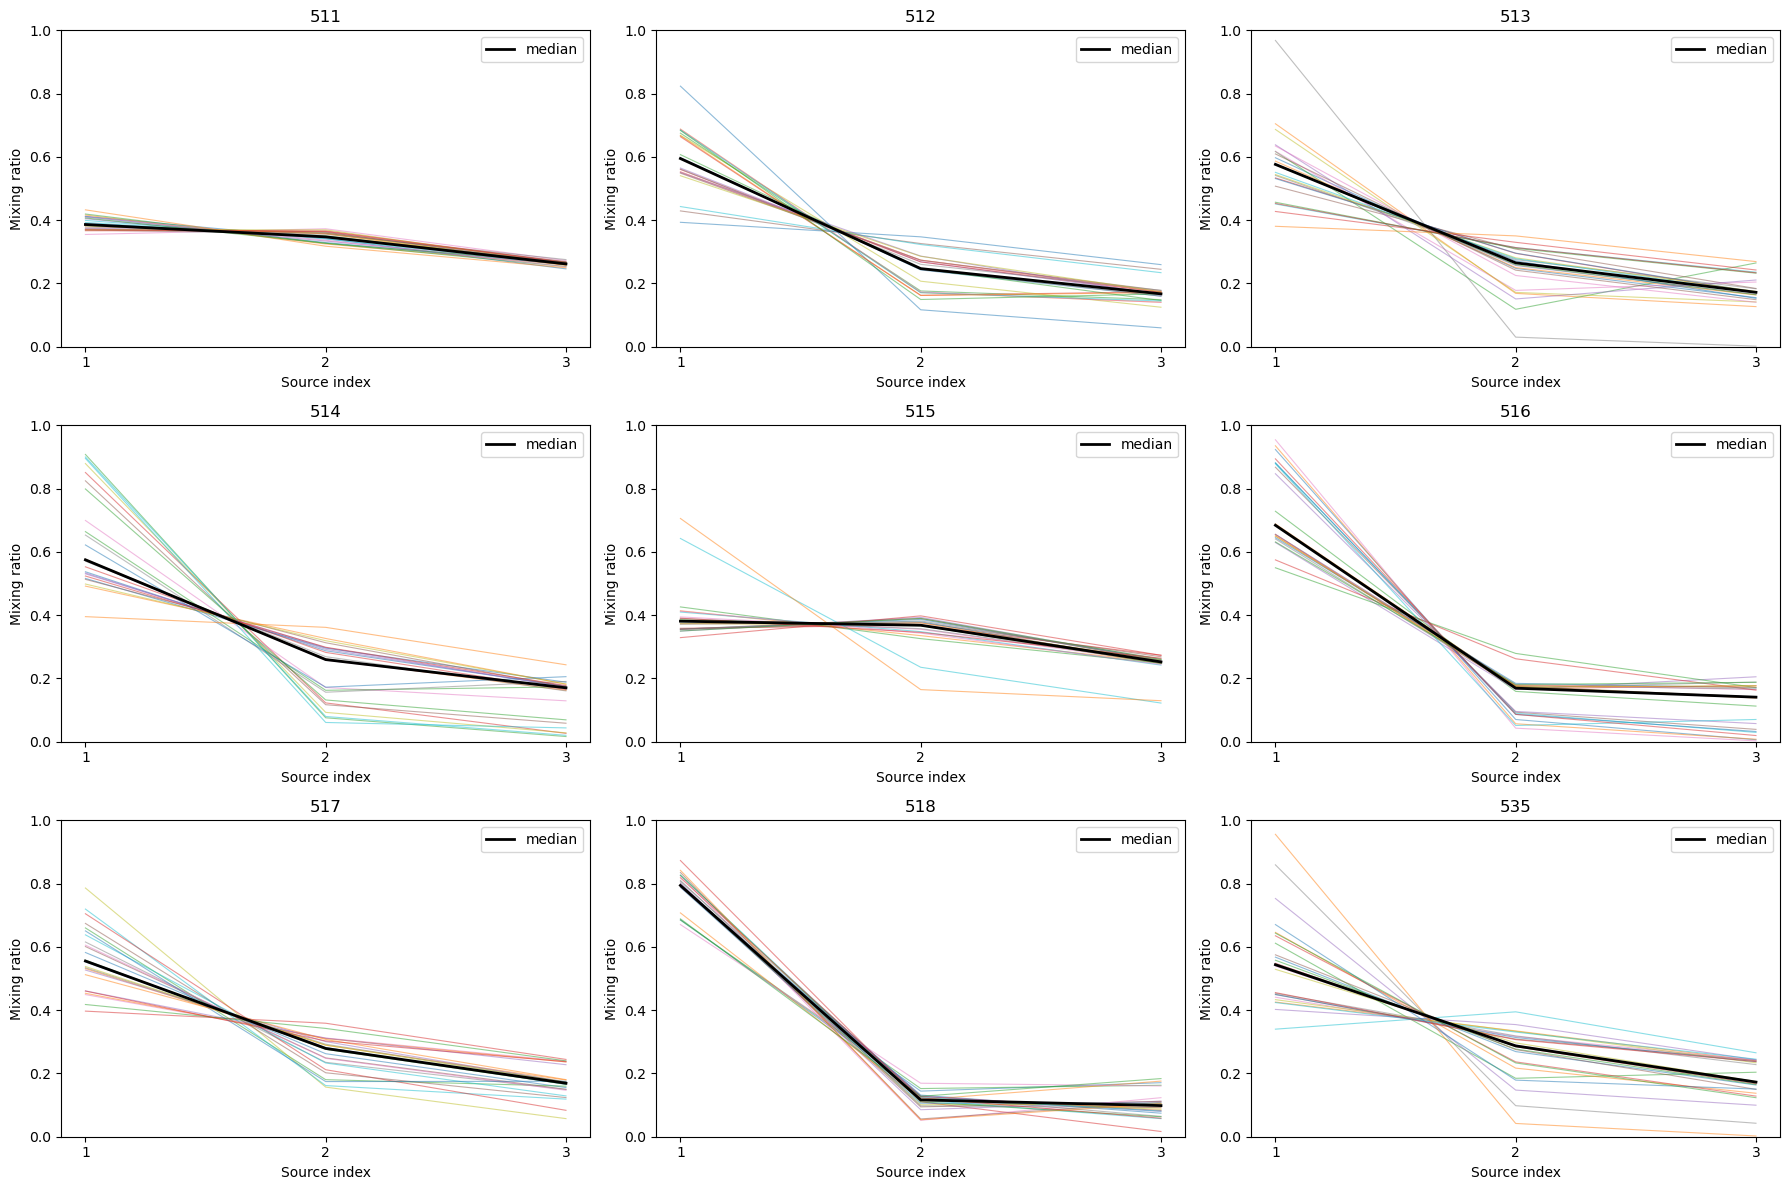

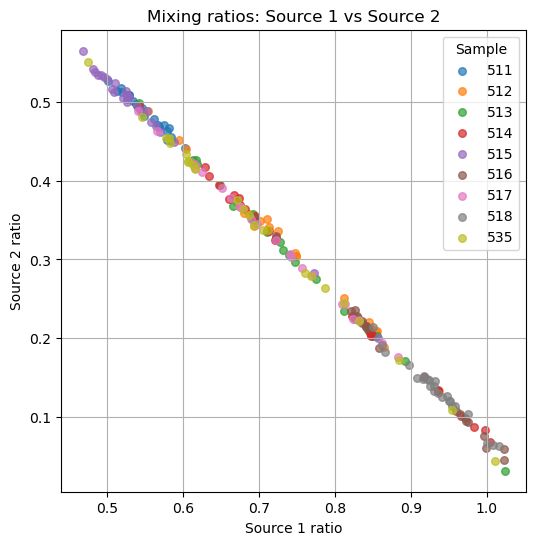

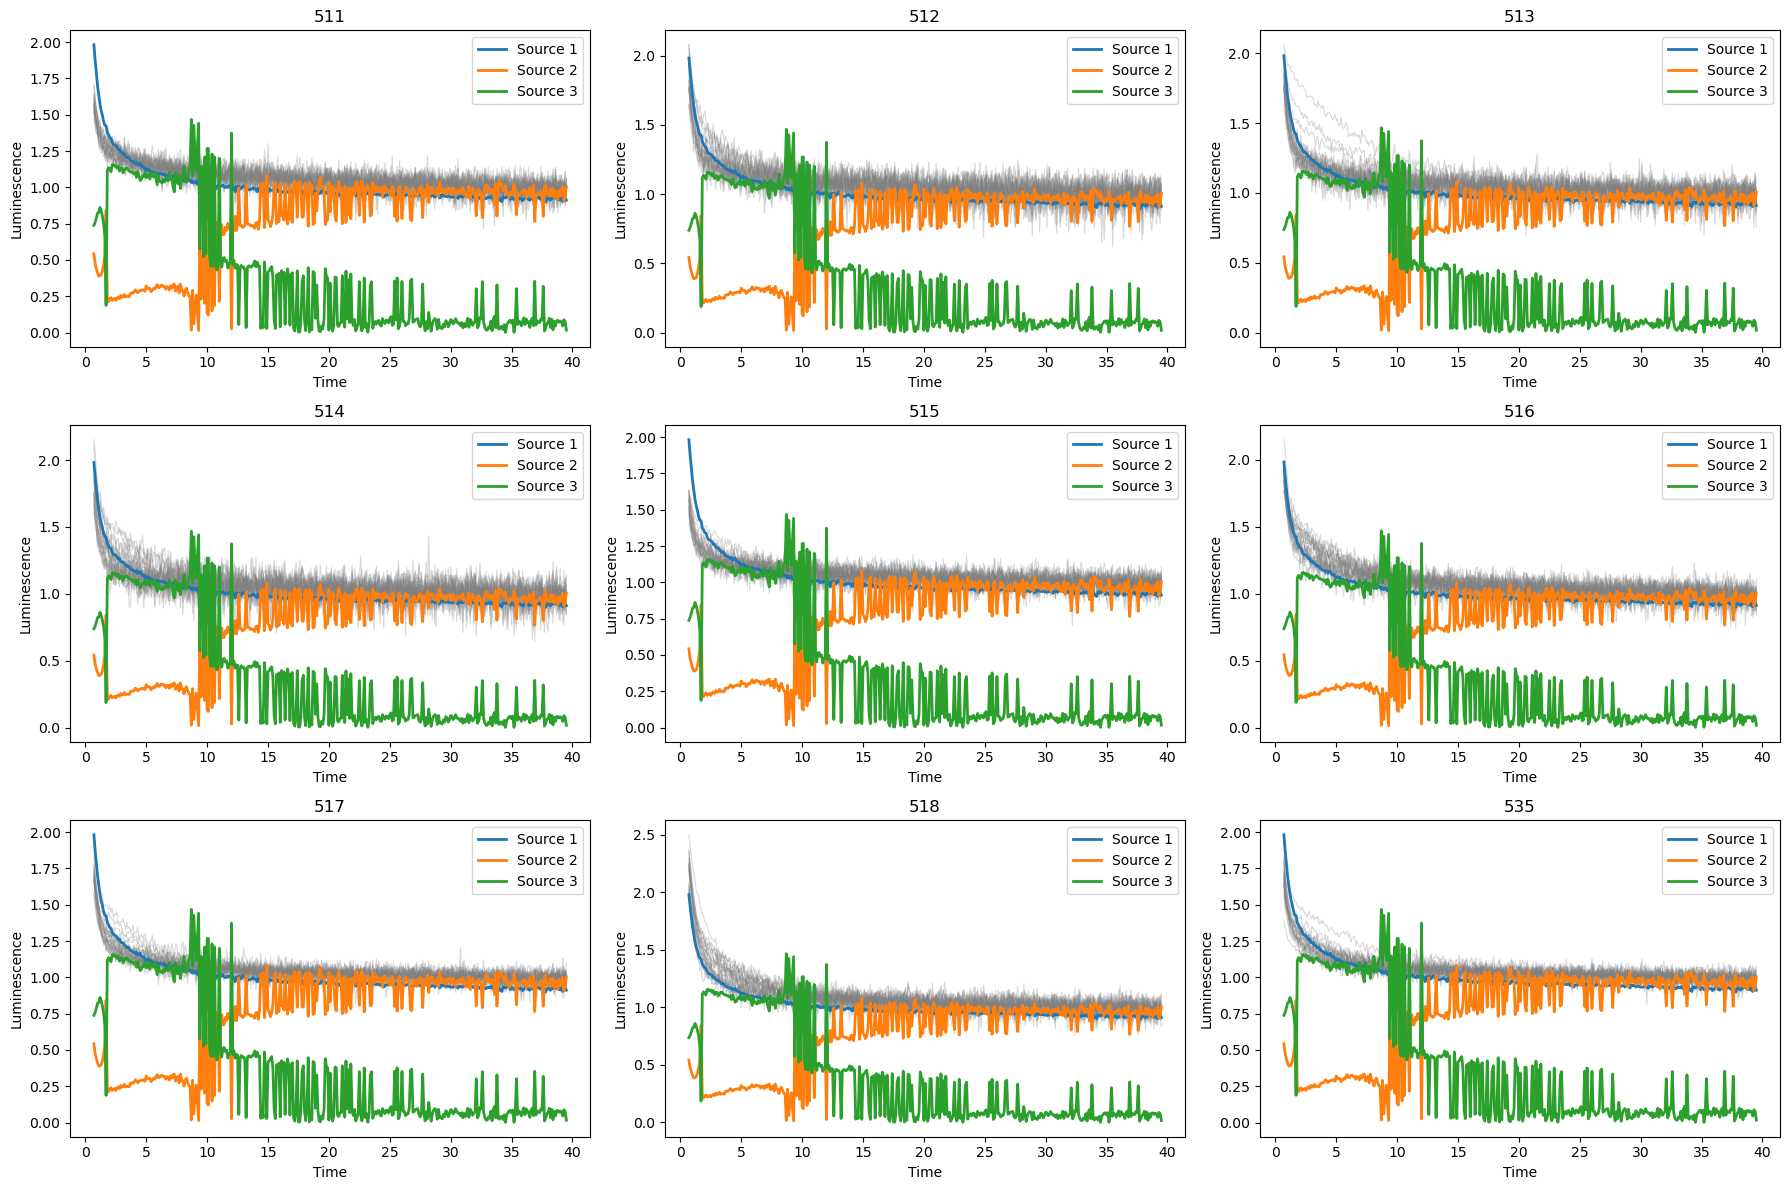

In [24]:
import numpy as np
import unicodedata
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
# from matplotlib.cm import get_cmap
from matplotlib import colormaps
from scipy.stats import zscore




# ------------------------------------------------------------
# Helper to canonicalise a sample label
# ------------------------------------------------------------
def canon(s):
    s = str(s).strip()                 # drop leading/trailing spaces
    s = unicodedata.normalize('NFKC', s)  # normalise unicode width
    return s

# ------------------------------------------------------------
# 1. Canonicalise sample_tag immediately after you build it
# ------------------------------------------------------------
sample_tag = np.array([canon(t) for t in sample_tag])

# 2. Unique list for plotting (already canonical)
unique_samples = sorted(set(sample_tag))

# ------------------------------------------------------------
# 2. Fit NMF (rank = 3)
# ------------------------------------------------------------
opt_r   = 3
nmf_opt = NMF(n_components=opt_r, init='nndsvda', solver='mu',
              max_iter=2000, random_state=1)
W_opt = nmf_opt.fit_transform(X)
W_norm = W_opt / W_opt.sum(axis=1, keepdims=True)

# print the shape of W_norm
print("Shape of W_norm:", W_norm.shape)  # (n_slices, n_sources)
print("Shape of H_opt:", nmf_opt.components_.shape)  # (n_sources, n_time)



# ------------------------------------------------------------
# 3. Mixing-ratio curves, 3×3 grid
# ------------------------------------------------------------
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.ravel()

# cmap = get_cmap('tab10')
cmap = colormaps['tab10']
col_dict = {s: cmap(i % 10) for i, s in enumerate(unique_samples)}

for ax, sample in zip(axes, unique_samples):
    idx = np.flatnonzero(sample_tag == sample)   # same as where()[0]

    if idx.size == 0:            # nothing matched ⇒ blank this pane
        ax.axis('off')
        continue

    w_sample = W_norm[idx]       # (#slices_in_sample × 3)
    x = np.arange(1, opt_r + 1)

    ax.plot(x, w_sample.T, lw=0.8, alpha=0.5)
    ax.plot(x, np.median(w_sample, axis=0),
            lw=2, color='black', label='median')
    # only show x ticks at rank=1,2,3
    ax.set_xticks(x)
    # ax.set_xticklabels([f'Source {i}' for i in x])
    ax.set(title=sample, xlabel='Source index',
           ylabel='Mixing ratio', ylim=(0, 1))
    ax.legend()

# any spare subplots
for ax in axes[len(unique_samples):]:
    ax.axis('off')

fig.tight_layout()
plt.show()

# ------------------------------------------------------------
# 4. Scatter of source-1 vs source-2 fractions
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 6))

for sample in unique_samples:
    idx = np.flatnonzero(sample_tag == sample)
    # ax.scatter(W_norm[idx, 0], W_norm[idx, 1],
    #            label=sample, alpha=0.7, s=30,
    #            color=col_dict[sample])
    ax.scatter(W_opt[idx, 0], W_opt[idx, 1],
               label=sample, alpha=0.7, s=30,
               color=col_dict[sample])
    
    # ax.scatter(zscore(W_opt[idx, 0]), zscore(W_opt[idx, 1]),
    #            label=sample, alpha=0.7, s=30,
    #            color=col_dict[sample])

ax.set(xlabel='Source 1 ratio', ylabel='Source 2 ratio',
       title='Mixing ratios: Source 1 vs Source 2'
) 
#        xlim=(0, 1), ylim=(0, 1)
ax.legend(title='Sample')
ax.grid(True)
plt.show()




# ------------------------------------------------------------
# 5.  “Sources-vs-Slices” diagnostic: 3 × 3 grid
# ------------------------------------------------------------
H_opt = nmf_opt.components_          # shape (3, n_time)
time  = time_axis                    # same x-axis for all

src_cmap   = plt.colormaps['tab10']  # any qualitative map you like
src_colors = [src_cmap(i) for i in range(3)]

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.ravel()

for ax, sample in zip(axes, unique_samples):
    idx = np.flatnonzero(sample_tag == sample)      # slices for this sample
    if idx.size == 0:
        ax.axis('off')
        continue

    # --- grey slice curves ----------------------------------
    ax.plot(time, X[idx].T, color='grey', alpha=0.3, lw=0.8)

    # --- the three source signatures ------------------------
    for k, (src, col) in enumerate(zip(H_opt, src_colors), start=1):
        ax.plot(time, src, color=col, lw=2,
                label=f'Source {k}')

    ax.set(title=sample, xlabel='Time', ylabel='Luminescence')
    ax.legend()

# hide unused panes if < 9 samples
for ax in axes[len(unique_samples):]:
    ax.axis('off')

fig.tight_layout()
plt.show()

Text(0, 0.5, 'Source 2 ratio')

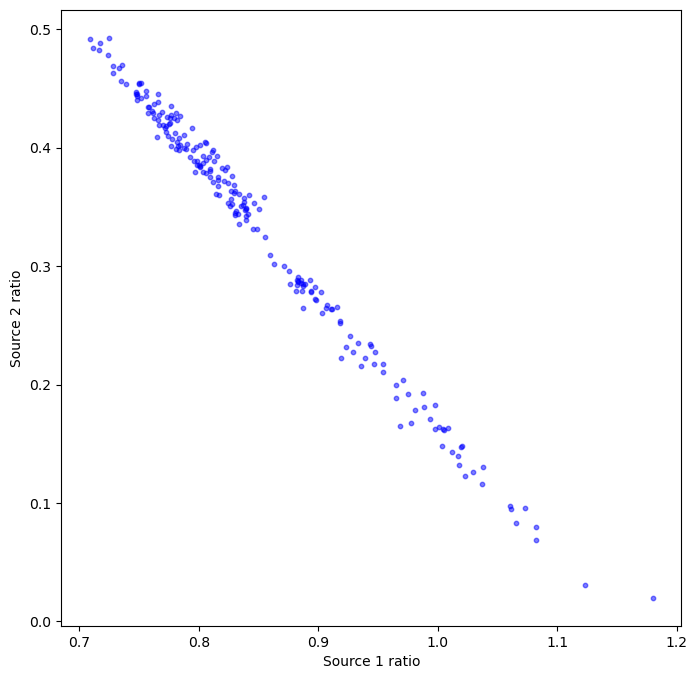

In [8]:
# Shape of W_norm: (215, 2), please plot a scatter plot of the two columns

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
# plt.scatter(W_norm[:, 0], W_norm[:, 1], alpha=0.5, s=10)
plt.scatter(W_opt[:, 0], W_opt[:, 1], alpha=0.5, s=10, c='blue')
plt.xlabel('Source 1 ratio')
plt.ylabel('Source 2 ratio')

# Transform H_opt back to check the shape

In [9]:
import numpy as np

def restore_sources(H_log,
                    slice_maxes,
                    offset=1e-9,
                    match='median',
                    pct=95):
    """
    Convert NMF end-member curves obtained on *log-data* back to
    something that looks like the original (linear-count) decay curves.

    Parameters
    ----------
    H_log : (r, n_time) ndarray
        nmf_opt.components_ – each row in log10(counts).
    slice_maxes : 1-D array
        For every slice in the *raw* data, its maximum count.
        You can compute it once with:  slice_maxes = raw_X.max(axis=1)
    offset : float, default 1e-9
        The small value you added before log10 to avoid log(0).
    match : {'median', 'percentile', 'none'}
        • 'median'      – multiply each source so its max equals the median
                           of slice_maxes.  
        • 'percentile'  – use the `pct`-th percentile of slice_maxes  
        • 'none'        – no additional scaling; just undo the log.
    pct : int, default 95
        Which percentile to match if `match='percentile'`.

    Returns
    -------
    H_lin : (r, n_time) ndarray
        End-member curves on the *linear* count scale.
    """

    # 1.  undo log10
    H_lin = 10.0**H_log - offset

    # 2.  choose a reference height from the slices
    if match == 'median':
        ref = np.median(slice_maxes)
    elif match == 'percentile':
        ref = np.percentile(slice_maxes, pct)
    else:                       # 'none'
        return H_lin

    # 3.  rescale each row so its max equals that reference
    for k in range(H_lin.shape[0]):
        H_lin[k] *= ref / H_lin[k].max()

    return H_lin



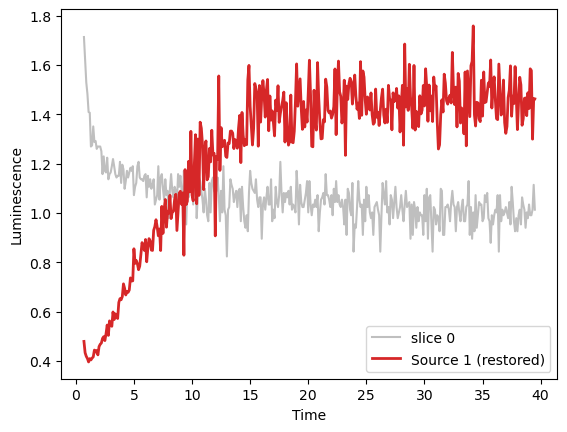

In [10]:
# raw_X is the (n_slices × n_time) matrix of *raw* counts (no log)
raw_X      = np.vstack(X_list)
slice_maxes = raw_X.max(axis=1)

H_restored = restore_sources(H_opt,
                             slice_maxes=slice_maxes,
                             offset=1e-9,
                             match='median')   # or 'percentile'

# quick check – plot Source 1 against an actual slice
import matplotlib.pyplot as plt

plt.plot(time_axis, raw_X[0],          color='grey', alpha=0.5, label='slice 0')
plt.plot(time_axis, H_restored[1],     color='tab:red',  lw=2,   label='Source 1 (restored)')
plt.legend()
plt.xlabel('Time'); plt.ylabel('Luminescence'); plt.show()


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import math

def analyse_sample(sample_name,
                   X=X, W=W_opt, H=H_opt,
                   tags=sample_tag, t=time_axis,
                   max_cols=4):
    """
    Visual sanity-check for one sample.
    
    Parameters
    ----------
    sample_name : str
        Name as it appears in `sample_tag` (case-sensitive).
    X, W, H : ndarray
        NMF ingredients. X = slices×time, W = slices×r, H = r×time.
    tags : ndarray
        Array parallel to X that stores the sample name of each slice.
    t : ndarray
        1-D time axis for the decay curves.
    max_cols : int
        Max. number of subplot columns (rows adjust automatically).
    """
    # ---- which rows belong to this sample? ---------------------------
    idx = np.flatnonzero(tags == sample_name)
    if idx.size == 0:
        raise ValueError(f'No slices found for sample "{sample_name}"')

    n_slices = idx.size
    n_cols   = min(max_cols, n_slices)
    n_rows   = math.ceil(n_slices / n_cols)

    # ---- figure set-up -----------------------------------------------
    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(4*n_cols, 2.5*n_rows),
                             sharex=True, sharey=True)
    axes = np.array(axes).ravel()   # 1-D view

    # ---- iterate over the slices -------------------------------------
    for k, (ax, row) in enumerate(zip(axes, idx)):
        original = X[row]                    # original decay curve
        recon    = W[row] @ H                # W·H reconstruction

        ax.plot(t, original, color='grey', lw=0.8, label='original')
        ax.plot(t, recon,   color='tab:red', lw=1.2, label='W·H')

        ax.set(title=f'slice {k+1}',
               xlabel='Time', ylabel='Luminescence')

        # tidy legend once per subplot grid
        if k == 0:
            ax.legend()
    # hide any spare panes
    for ax in axes[n_slices:]:
        ax.axis('off')

    fig.suptitle(f'Sample {sample_name}: original vs. NMF reconstruction',
                 fontsize=14, y=1.02)
    fig.tight_layout()
    plt.show()


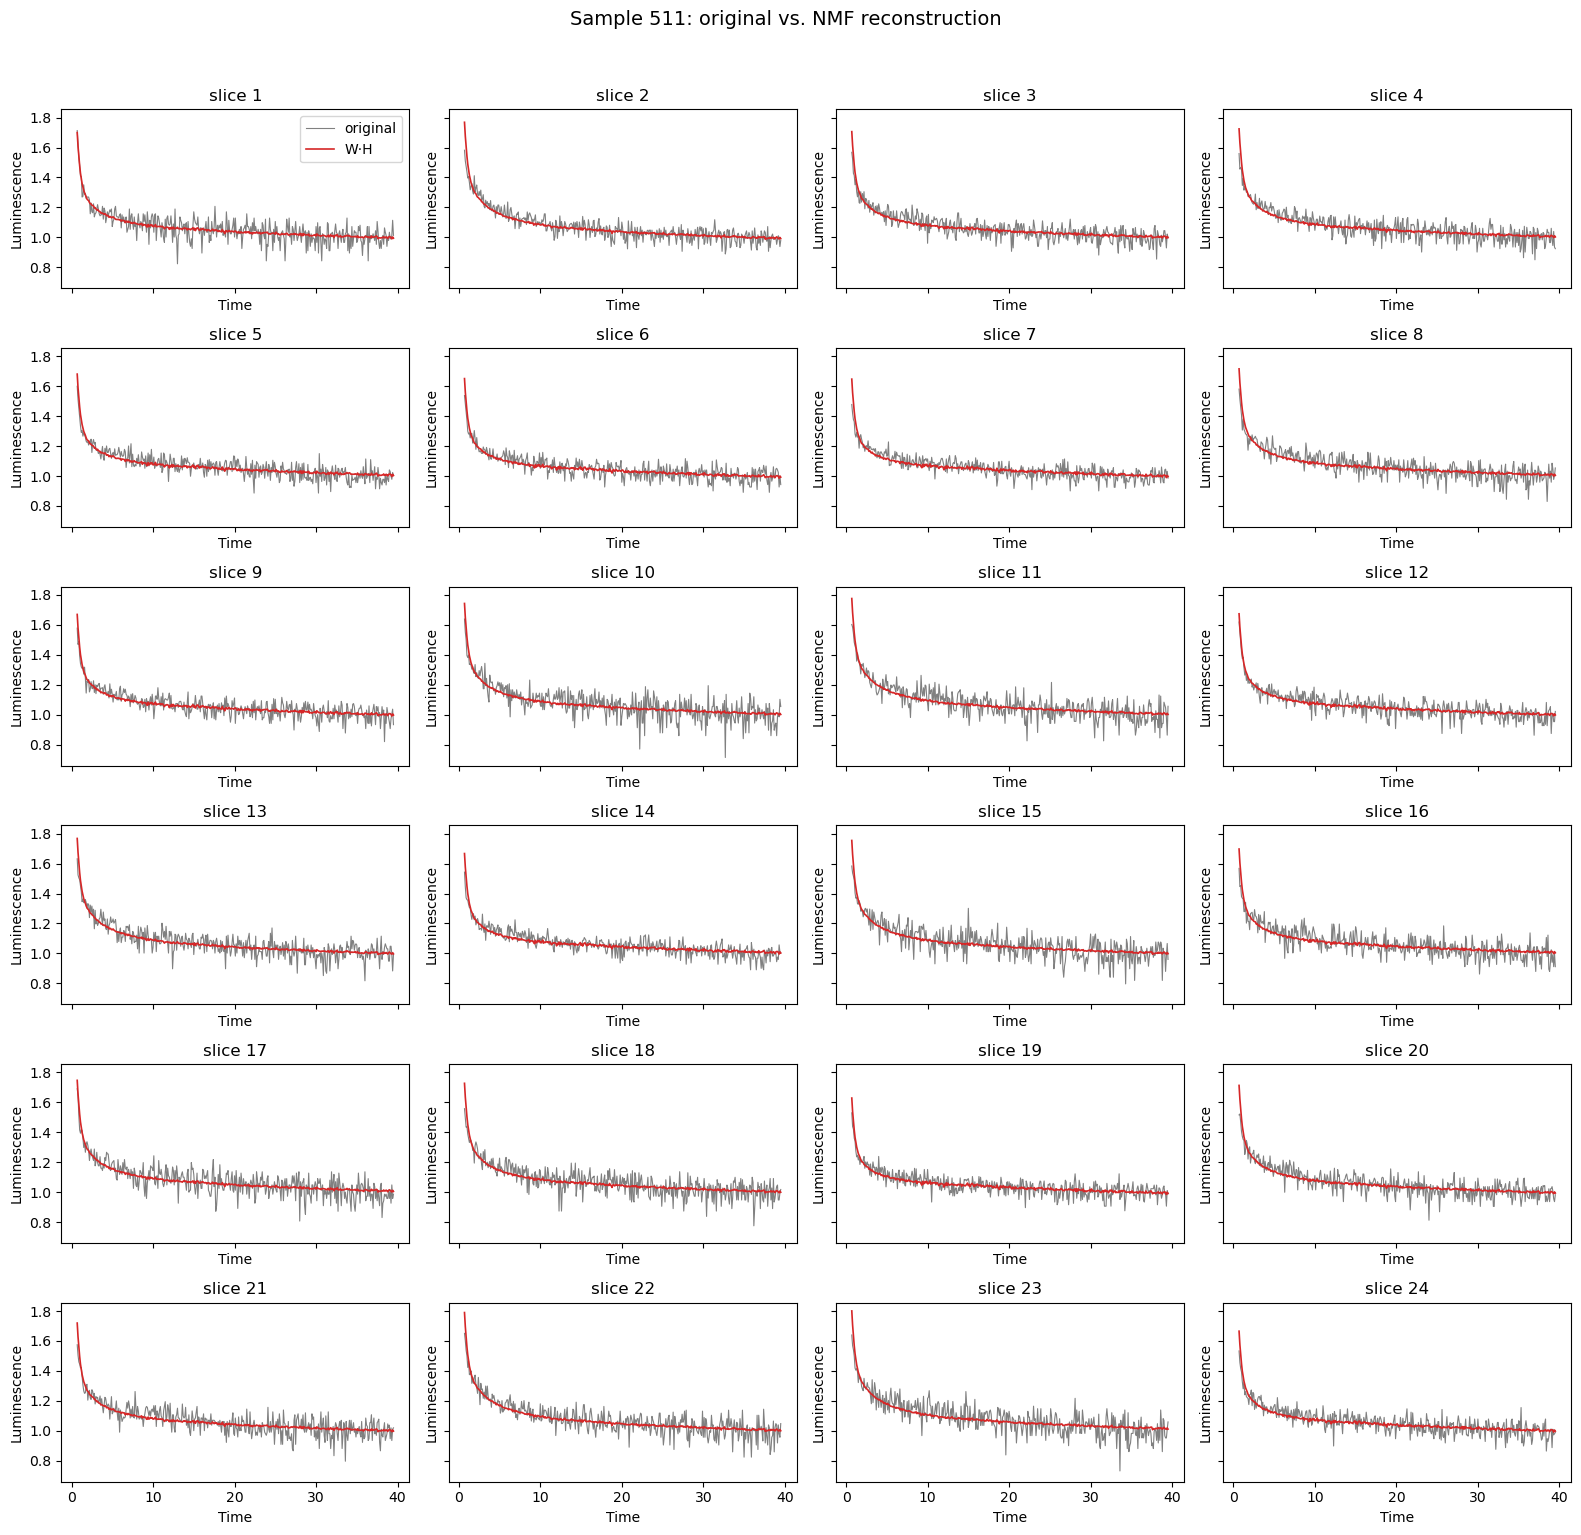

In [12]:
analyse_sample('511')       


# Robust NMF

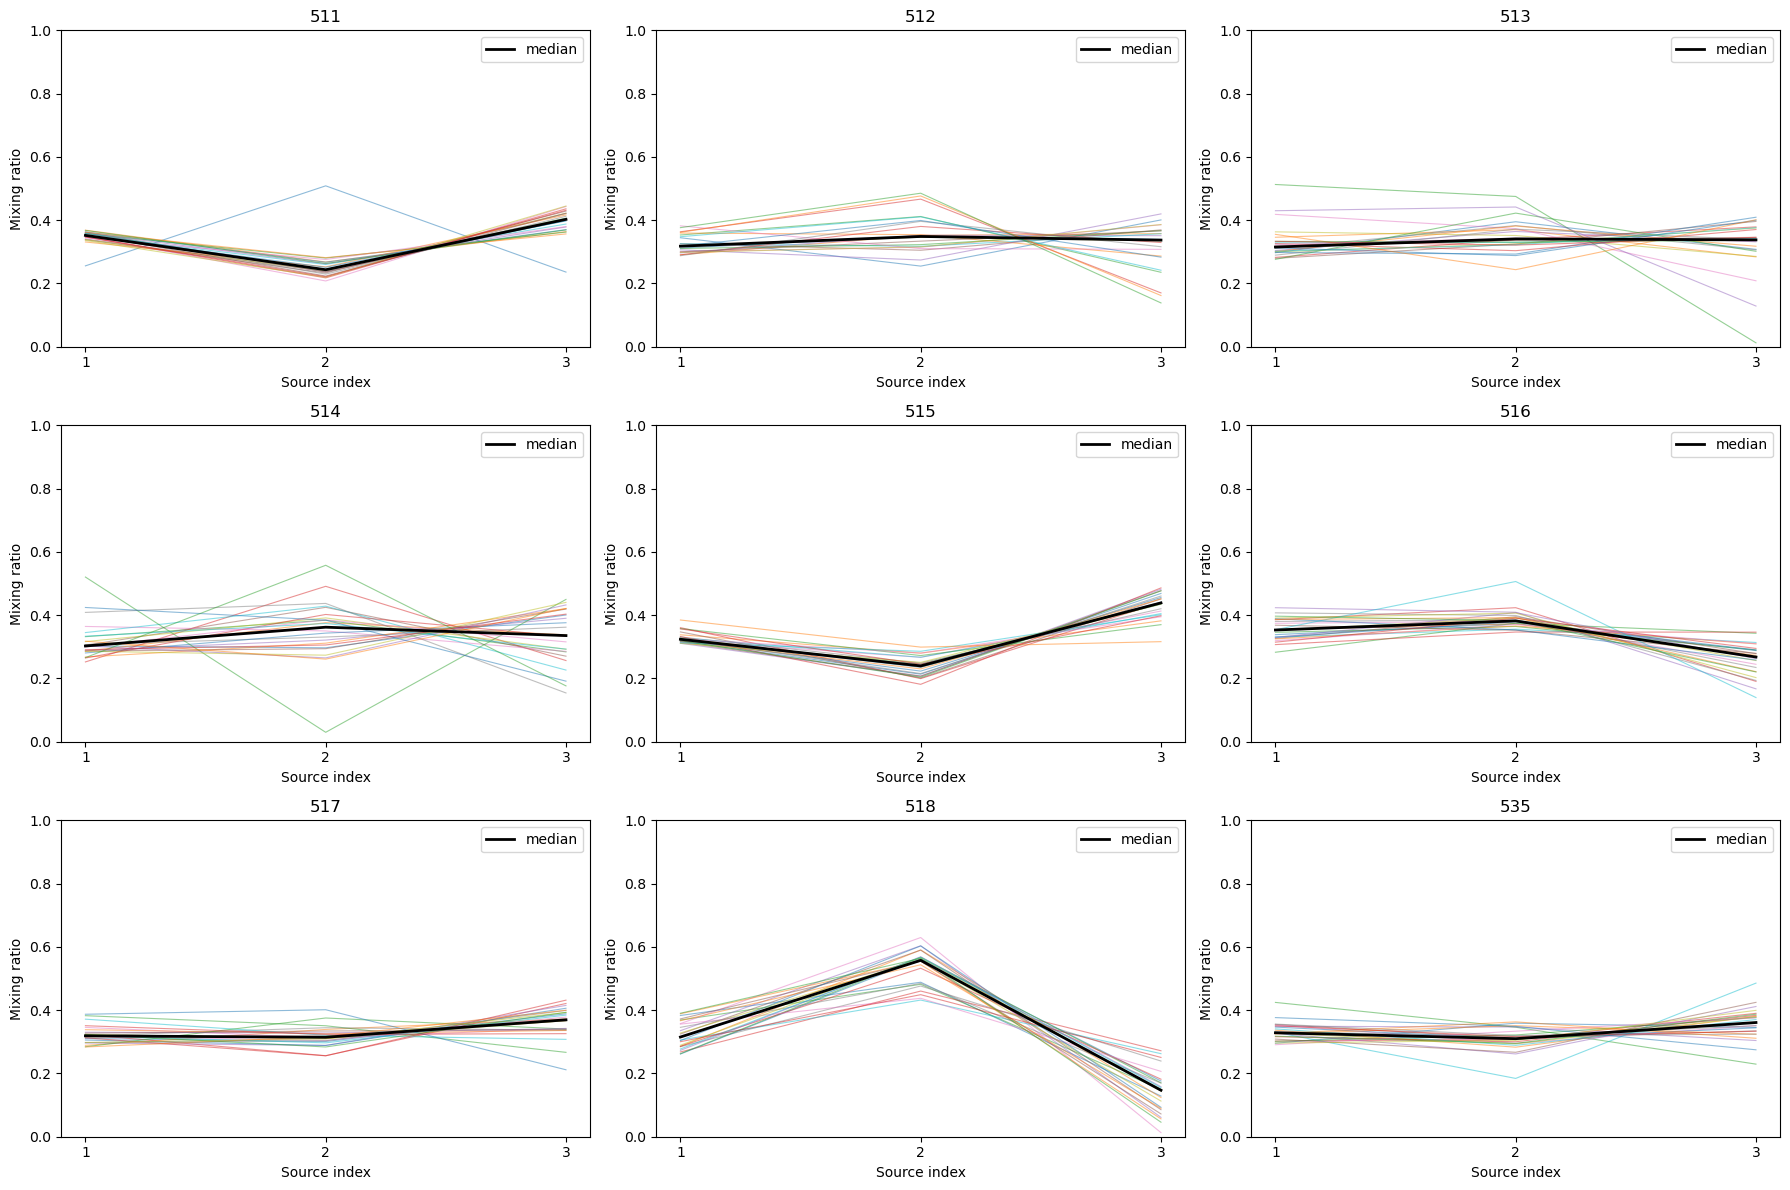

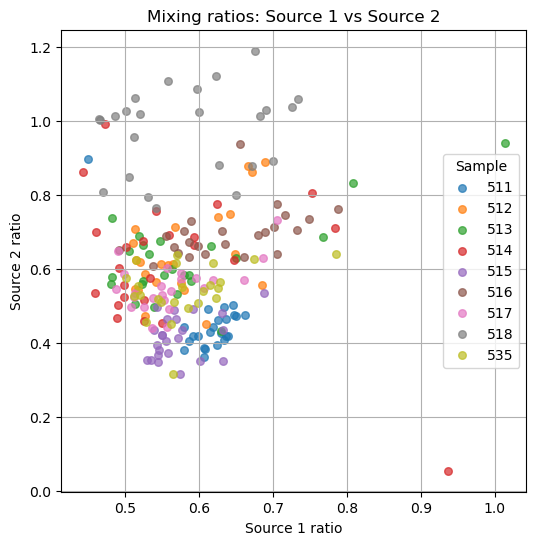

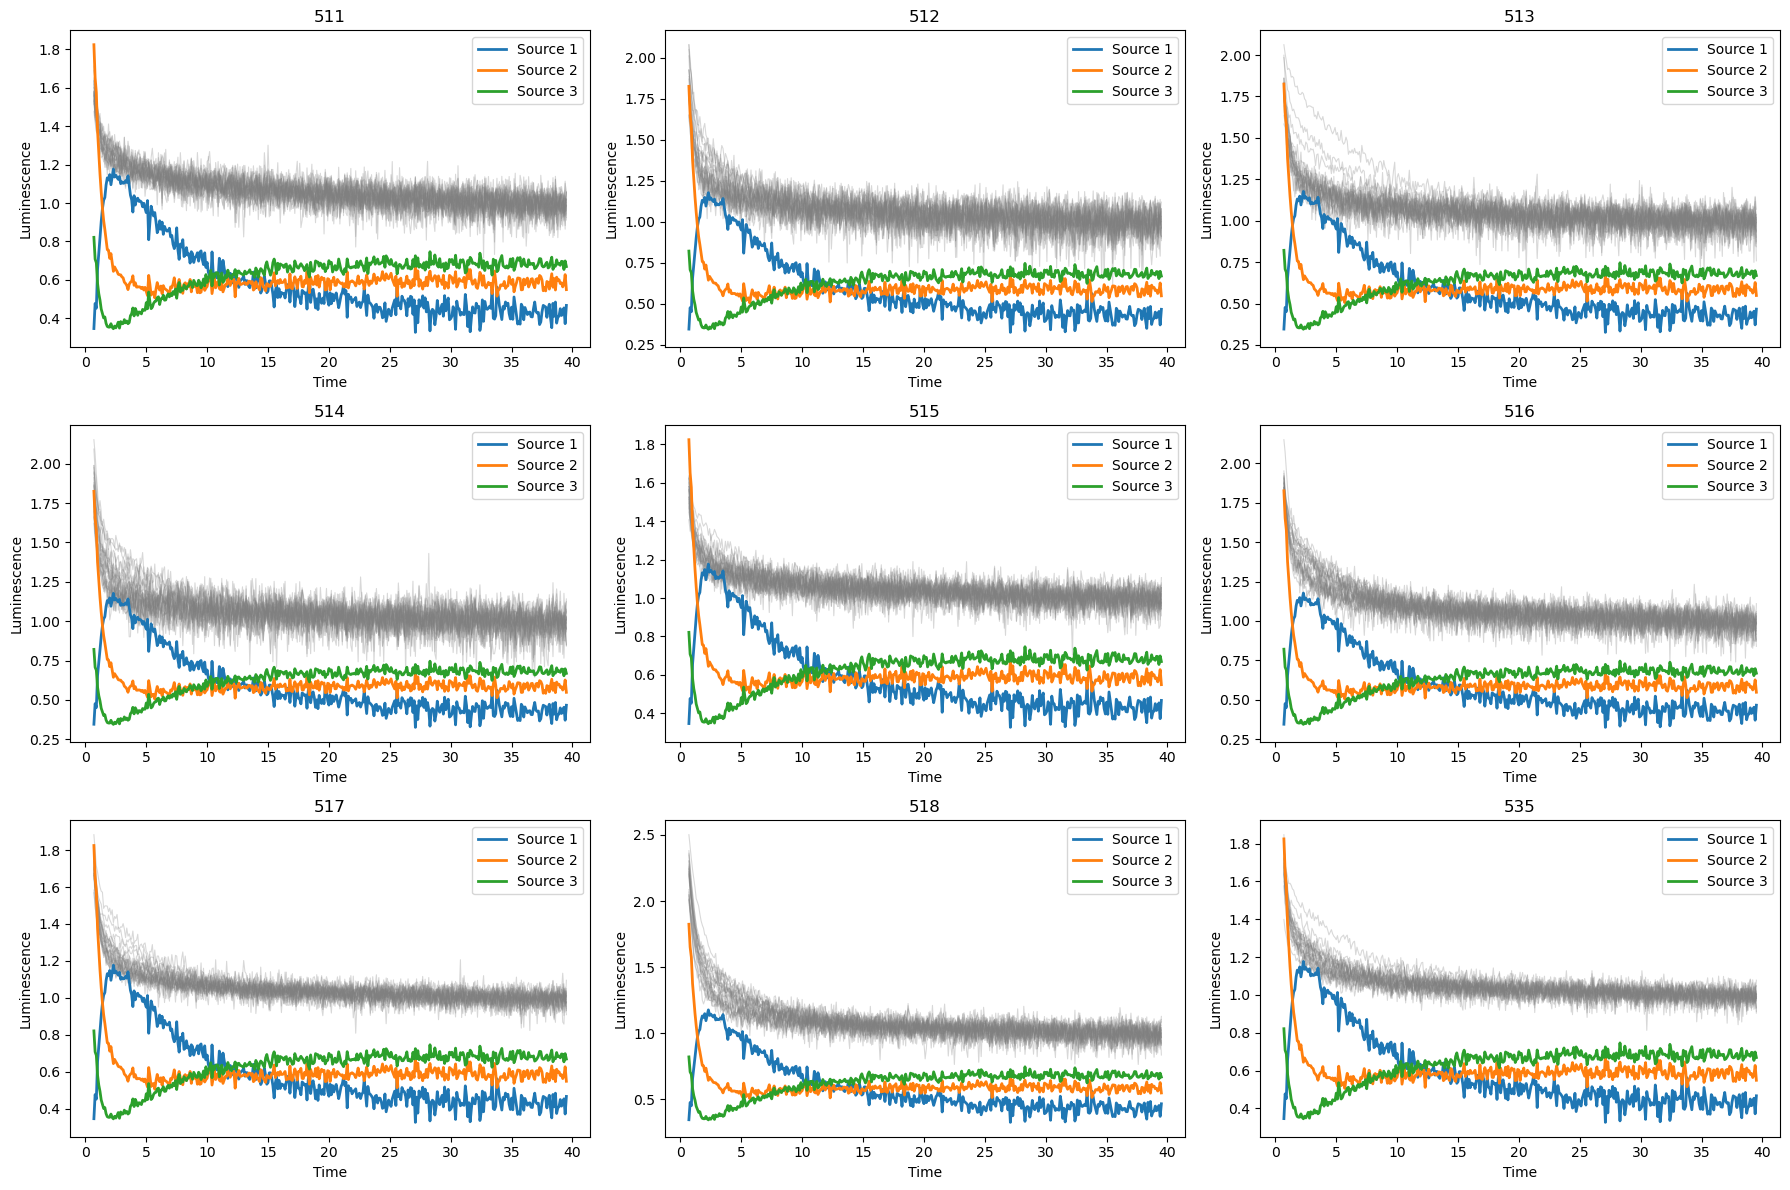

In [25]:
import os, pickle, numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib
from matplotlib.cm import get_cmap

# --------------------------------------------------------------------------------
# 0.  load processed data ---------------------------------------------------------
# --------------------------------------------------------------------------------
pickle_path = 'output/processed_data.pkl'
with open(pickle_path, 'rb') as f:
    data_dict = pickle.load(f)

# build X, sample_tag, time_axis
X_list, sample_tag = [], []
time_axis = None
for name, df in data_dict.items():
    if time_axis is None:
        time_axis = df['Time'].to_numpy(float)
    slice_cols = df.columns.difference(['Time_index', 'Time'])
    mat = df[slice_cols].to_numpy(float)      # (n_time, n_slices)
    X_list.append(mat.T)                      # (n_slices, n_time)
    sample_tag.extend([str(name).strip()]*mat.shape[1])

X = np.vstack(X_list)
sample_tag = np.array(sample_tag)
n_slices, n_time = X.shape

r = 3   # rank

# --------------------------------------------------------------------------------
# 1.  Robust NMF (simple MU + sparse residual soft-threshold) ---------------------
# --------------------------------------------------------------------------------
def robust_nmf(X, r, lam=0.05, max_iter=500, tol=1e-4, random_state=0):
    rng = np.random.RandomState(random_state)
    m, n = X.shape
    W = rng.rand(m, r) + 1e-4
    H = rng.rand(r, n) + 1e-4
    S = np.zeros_like(X)

    for it in range(max_iter):
        # update S via soft threshold
        residual = X - W @ H
        S_new = np.sign(residual) * np.maximum(np.abs(residual) - lam, 0)
        
        # update W, H using MU on X - S
        Xs = X - S_new
        WH = W @ H + 1e-9
        W *= (Xs @ H.T) / (WH @ H.T + 1e-9)
        H *= (W.T @ Xs) / (W.T @ WH + 1e-9)
        
        if it % 10 == 0:
            err = np.linalg.norm(X - W @ H - S_new) / np.linalg.norm(X)
            if err < tol:
                break
        S = S_new
    return W, H, S

W_opt, H_opt, S_opt = robust_nmf(X, r, lam=0.1, max_iter=1000, tol=1e-4, random_state=1)
W_norm = W_opt / W_opt.sum(axis=1, keepdims=True)

unique_samples = sorted(set(sample_tag))
# colour map for sources
src_cmap = matplotlib.colormaps['tab10']
src_colors = [src_cmap(i) for i in range(3)]
# colour dict per sample for scatter
sample_colors = {s: src_cmap(i+3) for i,s in enumerate(unique_samples)}


fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.ravel()

# cmap = get_cmap('tab10')
cmap = colormaps['tab10']
col_dict = {s: cmap(i % 10) for i, s in enumerate(unique_samples)}

for ax, sample in zip(axes, unique_samples):
    idx = np.flatnonzero(sample_tag == sample)   # same as where()[0]

    if idx.size == 0:            # nothing matched ⇒ blank this pane
        ax.axis('off')
        continue

    w_sample = W_norm[idx]       # (#slices_in_sample × 3)
    x = np.arange(1, opt_r + 1)

    ax.plot(x, w_sample.T, lw=0.8, alpha=0.5)
    ax.plot(x, np.median(w_sample, axis=0),
            lw=2, color='black', label='median')
    # only show x ticks at rank=1,2,3
    ax.set_xticks(x)
    # ax.set_xticklabels([f'Source {i}' for i in x])
    ax.set(title=sample, xlabel='Source index',
           ylabel='Mixing ratio', ylim=(0, 1))
    ax.legend()

# any spare subplots
for ax in axes[len(unique_samples):]:
    ax.axis('off')

fig.tight_layout()
plt.show()

# ------------------------------------------------------------
# 4. Scatter of source-1 vs source-2 fractions
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 6))

for sample in unique_samples:
    idx = np.flatnonzero(sample_tag == sample)
    # ax.scatter(W_norm[idx, 0], W_norm[idx, 1],
    #            label=sample, alpha=0.7, s=30,
    #            color=col_dict[sample])

    ax.scatter(W_opt[idx, 0], W_opt[idx, 1],
               label=sample, alpha=0.7, s=30,
               color=col_dict[sample])

ax.set(xlabel='Source 1 ratio', ylabel='Source 2 ratio',
       title='Mixing ratios: Source 1 vs Source 2',
)
ax.legend(title='Sample')
ax.grid(True)
plt.show()

# --------------------------------------------------------------------------------
# 4. Sources vs Slices overlay ----------------------------------------------------
# --------------------------------------------------------------------------------
fig_src, axes2 = plt.subplots(3,3, figsize=(18,12))
axes2 = axes2.ravel()

for ax, sample in zip(axes2, unique_samples):
    idx = np.flatnonzero(sample_tag==sample)
    if idx.size==0:
        ax.axis('off')
        continue
    ax.plot(time_axis, X[idx].T, color='grey', alpha=0.3, lw=0.8)
    for k in range(r):
        ax.plot(time_axis, H_opt[k], color=src_colors[k], lw=2, label=f'Source {k+1}')
    ax.set(title=sample, xlabel='Time', ylabel='Luminescence')
    ax.legend()
for ax in axes2[len(unique_samples):]:
    ax.axis('off')
fig_src.tight_layout()

plt.show()
